<img src=docs/tudelft_logo.jpg width=50%>

## Data-driven Design and Analyses of Structures and Materials (3dasm)

## Lecture 11

### Miguel A. Bessa | <a href = "mailto: M.A.Bessa@tudelft.nl">M.A.Bessa@tudelft.nl</a>  | Associate Professor

**What:** A lecture of the "3dasm" course

**Where:** This notebook comes from this [repository](https://github.com/bessagroup/3dasm_course)

**Reference for entire course:** Murphy, Kevin P. *Probabilistic machine learning: an introduction*. MIT press, 2022. Available online [here](https://probml.github.io/pml-book/book1.html)

**How:** We try to follow Murphy's book closely, but the sequence of Chapters and Sections is different. The intention is to use notebooks as an introduction to the topic and Murphy's book as a resource.
* If working offline: Go through this notebook and read the book.
* If attending class in person: listen to me (!) but also go through the notebook in your laptop at the same time. Read the book.
* If attending lectures remotely: listen to me (!) via Zoom and (ideally) use two screens where you have the notebook open in 1 screen and you see the lectures on the other. Read the book.

**Optional reference (the "bible" by the "bishop"... pun intended 😆) :** Bishop, Christopher M. *Pattern recognition and machine learning*. Springer Verlag, 2006.

**References/resources to create this notebook:**
* This simple tutorial is still based on a script I created for this article: https://imechanica.org/node/23957
* It follows from some examples provided by the scikit-learn user guide, which seem to have originated from Mathieu Blondel, Jake Vanderplas, Vincent Dubourg, and Jan Hendrik Metzen.
* Creating a new StandardScaler for Gaussian Processes: https://stats.stackexchange.com/questions/364418/how-to-get-the-prediction-std-using-gaussian-process-in-scikit-learn
* The flower to explain the Iris dataset comes from this [source](https://www.ritchieng.com/machine-learning-iris-dataset/)

Apologies in advance if I missed some reference used in this notebook. Please contact me if that is the case, and I will gladly include it here.

## **OPTION 1**. Run this notebook **locally in your computer**:
1. Confirm that you have the 3dasm conda environment (see Lecture 1).

2. Go to the 3dasm_course folder in your computer and pull the last updates of the [repository](https://github.com/bessagroup/3dasm_course):
```
git pull
```
3. Open command window and load jupyter notebook (it will open in your internet browser):
```
conda activate 3dasm
jupyter notebook
```
4. Open notebook of this Lecture.

## **OPTION 2**. Use **Google's Colab** (no installation required, but times out if idle):

1. go to https://colab.research.google.com
2. login
3. File > Open notebook
4. click on Github (no need to login or authorize anything)
5. paste the git link: https://github.com/bessagroup/3dasm_course
6. click search and then click on the notebook for this Lecture.

In [1]:
# Basic plotting tools needed in Python.

import matplotlib.pyplot as plt # import plotting tools to create figures
import numpy as np # import numpy to handle a lot of things!
from IPython.display import display, Math # to print with Latex math

%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
#plt.style.use("seaborn") # style for plotting that comes from seaborn
plt.rcParams["figure.figsize"] = (8,4) # rescale figure size appropriately for slides

## Outline for today

* Continuation of tutorial on supervised learning (again, no theory today!)
    - Multidimensional regression with Gaussian Processes and Artificial Neural Networks
* Classification with supervised learning: quick tutorial using Decision Trees and Support Vector Machines

**Reading material**: This notebook + (GPs in Section 17.3 of book; ANNs in Chapter 13)

## Today's lecture is also going to be more practical

Similarly to the previous lecture, we will focus on the practical aspects **without deriving the models yet**.

* We will continue to focus on regression via supervised learning with the same methods but now considering multiple dimensions:
    - **Gaussian Processes** using [scikit-learn](https://scikit-learn.org)
    - **Artificial Neural Networks** (ANNs) using [keras](https://keras.io/) and [tensorflow](https://www.tensorflow.org/)
* We will also do a quick example on classification via supervised learning with:
    - **Decision trees** using [scikit-learn](https://scikit-learn.org)
    - **Support vector machines** using [scikit-learn](https://scikit-learn.org)

Remember: there are many (many!) more ML models out there. We are covering a few simple ones... The hope is that you feel comfortable with applying and deriving different models!

# 1. Multidimensional regression

Similarly to what we did for one-dimension, now we are going to show how to do multidimensional regression with supervised learning.

As you will see, it's pretty much the same thing...

* We will use less obvious functions to generate our datasets for subsequent learning.


* There is a nice website listing many different benchmark functions used in optimization: https://www.sfu.ca/~ssurjano/optimization.html

Let's try to learn some of them...

In [2]:
# Line below is to enable live rotation of the surface plots.
%matplotlib notebook
#
from matplotlib import cm # to change colors of surface plots
#
# Let's define some functions that are often used to benchmark
# algorithms (especially in optimization)
def schwefel( x ):
    function_name = 'Schwefel' # to output name of function
    x = np.asarray_chkfinite(x)  # ValueError if any NaN or Inf
    if x.ndim == 1:
        x = np.reshape(x,(-1,2)) # reshape into 2d array
    #
    n_points, n_features = np.shape(x)
    y = np.empty((n_points,1))
    #
    for ii in range(n_points):
        y[ii] = 418.9829*n_features - sum( x[ii,:] * np.sin( np.sqrt( abs( x[ii,:] ))))
    return (np.atleast_1d(y), function_name)
#
# The next cell (hidden in presentation) includes a few more functions (so that you can play with this notebook).

In [3]:
def levy( x ):
    function_name = 'Levy' # to output name of function
    x = np.asarray_chkfinite(x)  # ValueError if any NaN or Inf
    if x.ndim == 1:
        x = np.reshape(x,(-1,2)) # reshape into 2d array
    #
    n_points, n_features = np.shape(x)
    y = np.empty((n_points,1))
    #
    for ii in range(n_points):
        z = 1 + (x[ii,:] - 1) / 4
        y[ii] = (np.sin( np.pi * z[0] )**2
            + sum( (z[:-1] - 1)**2 * (1 + 10 * np.sin( np.pi * z[:-1] + 1 )**2 ))
            +       (z[-1] - 1)**2 * (1 + np.sin( 2 * np.pi * z[-1] )**2 ))
    return (np.atleast_1d(y), function_name)
#
def ackley( x, a=20, b=0.2, c=2*np.pi ):
    function_name = 'Ackley' # to output name of function
    x = np.asarray_chkfinite(x)  # ValueError if any NaN or Inf
    if x.ndim == 1:
        x = np.reshape(x,(-1,2)) # reshape into 2d array
    #
    n_points, n_features = np.shape(x)
    y = np.empty((n_points,1))
    #
    for ii in range(n_points):
        s1 = sum( x[ii,:]**2 )
        s2 = sum( np.cos( c * x[ii,:] ))
        y[ii] = -a*np.exp( -b*np.sqrt( s1 / n_features )) - np.exp( s2 / n_features ) + a + np.exp(1)
    return (np.atleast_1d(y), function_name)
#
def rosenbrock( x ):  # rosen.m
    function_name = 'Rosenbrock' # to output name of function
    x = np.asarray_chkfinite(x)  # ValueError if any NaN or Inf
    if x.ndim == 1:
        x = np.reshape(x,(-1,2)) # reshape into 2d array
    #
    n_points, n_features = np.shape(x)
    y = np.empty((n_points,1))
    #
    for ii in range(n_points):
        x0 = x[ii,:-1]
        x1 = x[ii,1:]
        y[ii] = (sum( (1 - x0) **2 )
            + 100 * sum( (x1 - x0**2) **2 ))
    return (np.atleast_1d(y), function_name)
#

def griewank( x, fr=4000 ):
    function_name = 'Griewank' # to output name of function
    x = np.asarray_chkfinite(x)  # ValueError if any NaN or Inf
    if x.ndim == 1:
        x = np.reshape(x,(-1,2)) # reshape into 2d array
    #
    n_points, n_features = np.shape(x)
    y = np.empty((n_points,1))
    #
    j = np.arange( 1., n_features+1 )
    for ii in range(n_points):
        s = sum( x[ii,:]**2 )
        p = np.prod( np.cos( x[ii,:] / np.sqrt(j) ))
        y[ii] = s/fr - p + 1
    return (np.atleast_1d(y), function_name)
#
def rastrigin( x ):  # rast.m
    function_name = 'Rastrigin' # to output name of function
    x = np.asarray_chkfinite(x)  # ValueError if any NaN or Inf
    if x.ndim == 1:
        x = np.reshape(x,(-1,2)) # reshape into 2d array
    #
    n_points, n_features = np.shape(x)
    y = np.empty((n_points,1))
    #
    for ii in range(n_points):
        y[ii] = 10*n_features + sum( x[ii,:]**2 - 10 *
                                np.cos( 2 * np.pi * x[ii,:] ))
    return (np.atleast_1d(y), function_name)
#
# end of functions for benchmark.

#
seed = 1987 # set a random seed to replicate results
np.random.seed(seed)

<a id='#create_dataset'></a>

Let's start by considering equally spaced sampling points, as we did in our previous lectures.

In [4]:
# Uniform grid of points for two-dimensional input
n_points_per_dimension = 50
x1 = np.linspace(-10.0, 10.0, n_points_per_dimension)
x2 = np.linspace(-10.0, 10.0, n_points_per_dimension)
# x3 = np.linspace(-10.0, 10.0, n_points_per_dimension) # if the input was 3D

X1_grid, X2_grid = np.meshgrid(x1, x2) # creates a grid of points that is necessary to plot surfaces
#X1_grid, X2_grid, X3_grid = np.meshgrid(x1, x2, x3) # e.g. for 3D input

print("Note that the X1_grid (and X2_grid) are 2D arrays with the following size:\n", np.shape(X1_grid))

# Input points reshaped for Pandas dataframe
Data_X = np.array([X1_grid, X2_grid]).reshape(2, -1).T
#Data_X = np.array([X1_grid, X2_grid, X3_grid]).reshape(3, -1).T

Note that the X1_grid (and X2_grid) are 2D arrays with the following size:
 (50, 50)


In [5]:
# Output data created from one of the benchmark functions:
# levy, ackley, rosenbrock, schwefel, griewank, rastrigin
Data_y, function_name = schwefel(Data_X) # calculate the output vector Data_y (1D output) from input data (2D input)

print("The output of the function is a vector with size:\n", np.shape(Data_y))

# Reshape output data for use in Surface plot:
Y_grid = np.reshape(Data_y,np.shape(X1_grid))

print("So, we reshape the output vector into a 2D array needed to plot surfaces:\n", np.shape(Y_grid))

# Set the color scheme used in every plot:
set_cm = cm.cool # viridis, inferno, copper, PuBu, cool, coolwarm, hsv

The output of the function is a vector with size:
 (2500, 1)
So, we reshape the output vector into a 2D array needed to plot surfaces:
 (50, 50)


Let's plot the function in a few different ways:
* Left subplot: 3D surface of the function
* Right subplot: a wireframe of the surface (no colors)

<IPython.core.display.Javascript object>


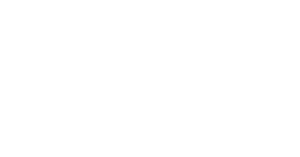

In [6]:
fig1 = plt.figure(figsize=plt.figaspect(0.5)); ax1 = [];
# Subplot 1 (left) of Figure 1
ax1.append(fig1.add_subplot(1, 2, 1, projection='3d')) # just a way to use the same variable for all axes of fig1.
# Surface plot:
surf = ax1[0].plot_surface(X1_grid, X2_grid, Y_grid, cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax1[0].set_xlabel('$x_1$', fontsize=15)
ax1[0].set_ylabel('$x_2$', fontsize=15)
ax1[0].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax1[0].set_title("%s function" % function_name, fontsize=15)

# Subplot 2 (right) of Figure 1
ax1.append(fig1.add_subplot(1, 2, 2, projection='3d'))
# Plot a 3D wireframe (no colors)
ax1[1].plot_wireframe(X1_grid, X2_grid, Y_grid, rstride=5, cstride=5)
ax1[1].set_xlabel('$x_1$', fontsize=15)
ax1[1].set_ylabel('$x_2$', fontsize=15)
ax1[1].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax1[1].set_title("%s function" % function_name, fontsize=15)
#plt.tight_layout() # if we want to enlarge the figures, but sometimes this leads to label occlusion.
plt.close(fig1)

<IPython.core.display.Javascript object>


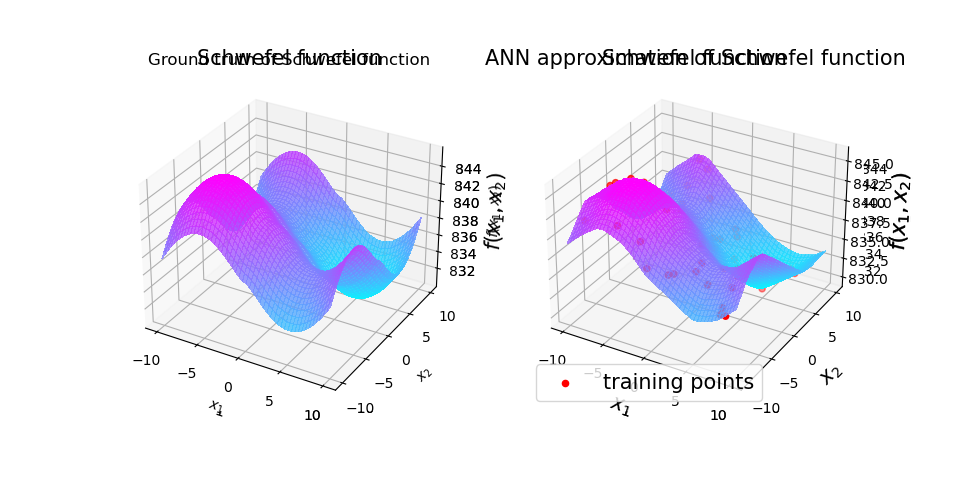

In [7]:
fig1

In the next figure, we show a contour plot of the same function.

<IPython.core.display.Javascript object>


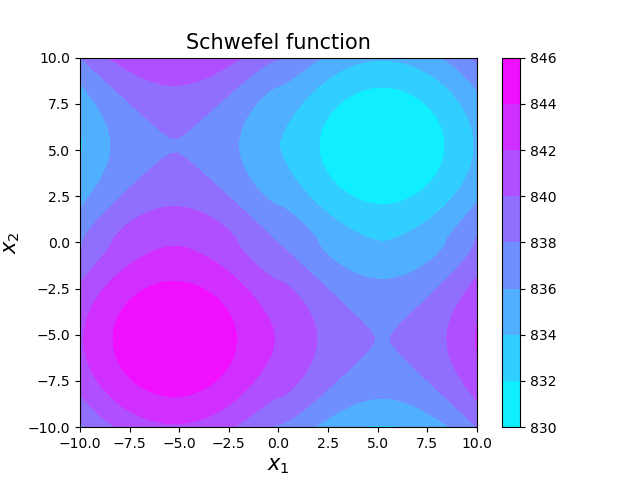

In [8]:
fig2, ax2 = plt.subplots()
cset = ax2.contourf(X1_grid, X2_grid, Y_grid, cmap=set_cm)
ax2.set_xlabel('$x_1$', fontsize=15)
ax2.set_ylabel('$x_2$', fontsize=15)
ax2.set_title("%s function" % function_name, fontsize=15)
fig2.colorbar(cset, ax=ax2)

Let's create a pandas dataframe for the above dataset, i.e. for the inputs (features 'x1' and 'x2') and outputs (target 'y1').

In [9]:
import pandas as pd
input_dictionary = {
            'x1' : Data_X[:,0],
            'x2' : Data_X[:,1],
            #'x3' : Data_X[:,2],
            'y1' : Data_y[:,0]
            }
#
# Then, we create a Pandas data frame:
df = pd.DataFrame(input_dictionary)

print(df)

             x1    x2          y1
0    -10.000000 -10.0  837.552129
1     -9.591837 -10.0  838.185887
2     -9.183673 -10.0  838.777493
3     -8.775510 -10.0  839.323512
4     -8.367347 -10.0  839.820614
...         ...   ...         ...
2495   8.367347  10.0  836.110986
2496   8.775510  10.0  836.608088
2497   9.183673  10.0  837.154107
2498   9.591837  10.0  837.745713
2499  10.000000  10.0  838.379471

[2500 rows x 3 columns]


In Lecture 2 we already introduced pandas. Take a look at how to access the data in 3 different ways:

1. Direct way to select columns & rows by how they were labeled originaly


2. DataFrame.loc to select columns & rows by Name


3. DataFrame.iloc to select columns & rows by Index Positions (integer numbers)

In [10]:
# Let's access every row of feature 'x1' and of target 'y1':
way1 = df[['x1','y1']] # direct way

way2 = df.loc[:,['x1','y1']] # using the labels of rows and columns

way3 = df.iloc[:,[0,2]] # using indices (integers) of rows and columns

print('way 1 =\n', way1, '\n\n') # the '\n' is to make a new line for visualization purposes only.
print('way 2 =\n', way2, '\n\n')
print('way 3 =\n', way3, '\n\n')

way 1 =
              x1          y1
0    -10.000000  837.552129
1     -9.591837  838.185887
2     -9.183673  838.777493
3     -8.775510  839.323512
4     -8.367347  839.820614
...         ...         ...
2495   8.367347  836.110986
2496   8.775510  836.608088
2497   9.183673  837.154107
2498   9.591837  837.745713
2499  10.000000  838.379471

[2500 rows x 2 columns] 


way 2 =
              x1          y1
0    -10.000000  837.552129
1     -9.591837  838.185887
2     -9.183673  838.777493
3     -8.775510  839.323512
4     -8.367347  839.820614
...         ...         ...
2495   8.367347  836.110986
2496   8.775510  836.608088
2497   9.183673  837.154107
2498   9.591837  837.745713
2499  10.000000  838.379471

[2500 rows x 2 columns] 


way 3 =
              x1          y1
0    -10.000000  837.552129
1     -9.591837  838.185887
2     -9.183673  838.777493
3     -8.775510  839.323512
4     -8.367347  839.820614
...         ...         ...
2495   8.367347  836.110986
2496   8.775510  836.

In [11]:
# Now let's access rows 2 until 5 (inclusive) of feature 'x2' an target 'y1':

# I think we can't do that by the direct way (correct me if I am wrong)
way2 = df.loc[2:5,['x2','y1']] # using the labels of data. Note that here when we write 2:5 (it includes)
                               # row with index 5

way3 = df.iloc[2:6,[1,2]] # using indices (integers) of the data note that we write 2:6 to include 5,
                          # which differs from way2 (!).
# way3 = df.iloc[2:6,1:3] # Alternative to accessing 'x2' and 'y1' by writing 1:3 instead of [1,2]

print('Specific rows, way 2 =\n', way2, '\n\n')
print('Specific rows, way 3 =\n', way3, '\n\n')

Specific rows, way 2 =
      x2          y1
2 -10.0  838.777493
3 -10.0  839.323512
4 -10.0  839.820614
5 -10.0  840.265605 


Specific rows, way 3 =
      x2          y1
2 -10.0  838.777493
3 -10.0  839.323512
4 -10.0  839.820614
5 -10.0  840.265605 




Now let's load our data into numpy variables from our Pandas DataFrame.

In [12]:
X_data = df.loc[:,['x1','x2']].values # note that we ask for the values, not a subset of the DataFrame
y_data = df.loc[:,'y1'].values

print(X_data)
print(y_data)

[[-10.         -10.        ]
 [ -9.59183673 -10.        ]
 [ -9.18367347 -10.        ]
 ...
 [  9.18367347  10.        ]
 [  9.59183673  10.        ]
 [ 10.          10.        ]]
[837.55212937 838.18588668 838.77749275 ... 837.15410725 837.74571332
 838.37947063]


<a id='#split_dataset'></a>

As usual, split the dataset into training and testing sets.

* For now, let's split the data with the following ratio: 2% for training set, and 98% for testing set

Note: the commonly used ratio is 75% for training and 25% for testing, but we will use Gaussian Processes and they can learn from very little data.

In [13]:
# Train/test split like we did before!
from sklearn.model_selection import train_test_split

testset_ratio = 0.98 # ratio of test set points from the dataset

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size=testset_ratio,random_state=seed)

## 1.1. Multidimensional regression with Gaussian Processes

Let's create a Gaussian Process Regression model for this training data and fit it to the entire dataset as well as to the test data.

In [14]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, ConstantKernel

# Define the kernel function
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) # This is the standard RBF kernel
#kernel = 1.0 * RBF(10, (1e-2, 1e2)) # Same kernel as above
                                    #(scikit-learn assumes constant
                                    # variance if you just write RBF
                                    # without the constant kernel or
                                    # without multiplying by 1.0)

# Other examples of kernels:
#kernel = ExpSineSquared(length_scale=3.0, periodicity=3.14,
#                       length_scale_bounds=(0.1, 10.0),
#                       periodicity_bounds=(0.1, 10)) * RBF(3.0, (1e-2, 1e2))
#kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2),nu=1.5)
                
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, n_restarts_optimizer=20) # using a small alpha

# Fit to data using Maximum Likelihood Estimation of the parameters
gp_model.fit(X_train, y_train) # here I am not scaling the target variable; only the features.

# Make the prediction on the entire dataset (for plotting), both for mean and standard deviation
y_data_GPpred, sigma_data_GPpred = gp_model.predict(X_data, return_std=True)

# Predict for test set (for error metric)
y_test_GPpred, sigma_test_GPpred = gp_model.predict(X_test, return_std=True)

/home/mabessa/miniconda3/envs/3dasm/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


**IMPORTANT**: You probably got a warning message saying that convergence of the optimizer failed or saying that the optimal value for the paramater of the constant kernel is close to the bounds you defined (in ConstantKernel)

This is not just a minor "detail". It has important implications!
* This is a direct consequence of us not **pre-processing** the data adequately.

Before learning how to pre-process the data, let's visualize our GPR model and compare it to the ground truth function.

<IPython.core.display.Javascript object>


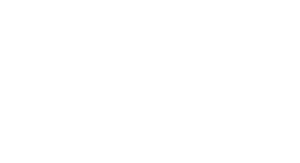

In [15]:
fig3_WRONG = plt.figure(figsize=plt.figaspect(0.5)); ax3_WRONG = []
# Subplot 1 (left): ground truth
ax3_WRONG.append(fig3_WRONG.add_subplot(1, 2, 1, projection='3d'))
surf = ax3_WRONG[0].plot_surface(X1_grid, X2_grid, Y_grid,
                                 cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax3_WRONG[0].set_xlabel('$x_1$', fontsize=15)
ax3_WRONG[0].set_ylabel('$x_2$', fontsize=15)
ax3_WRONG[0].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax3_WRONG[0].set_title("Ground truth of %s function" % function_name, fontsize=15)

# Subplot 2 (right): GPR approximation
ax3_WRONG.append(fig3_WRONG.add_subplot(1, 2, 2, projection='3d'))
Y_grid_data_GPpred = np.reshape(y_data_GPpred,np.shape(X1_grid)) # convert targets into grid format for plotting
surf = ax3_WRONG[1].plot_surface(X1_grid, X2_grid, Y_grid_data_GPpred,
                                 cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax3_WRONG[1].set_xlabel('$x_1$', fontsize=15)
ax3_WRONG[1].set_ylabel('$x_2$', fontsize=15)
ax3_WRONG[1].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax3_WRONG[1].set_title("GPR mean for %s function" % function_name, fontsize=15)
ax3_WRONG[1].scatter(X_train[:,0], X_train[:,1], y_train, marker='o', color='red', label="training points")
ax3_WRONG[1].legend(loc='upper center')
#plt.tight_layout()
plt.close(fig3_WRONG) # close figure to open it in next cell.

<IPython.core.display.Javascript object>


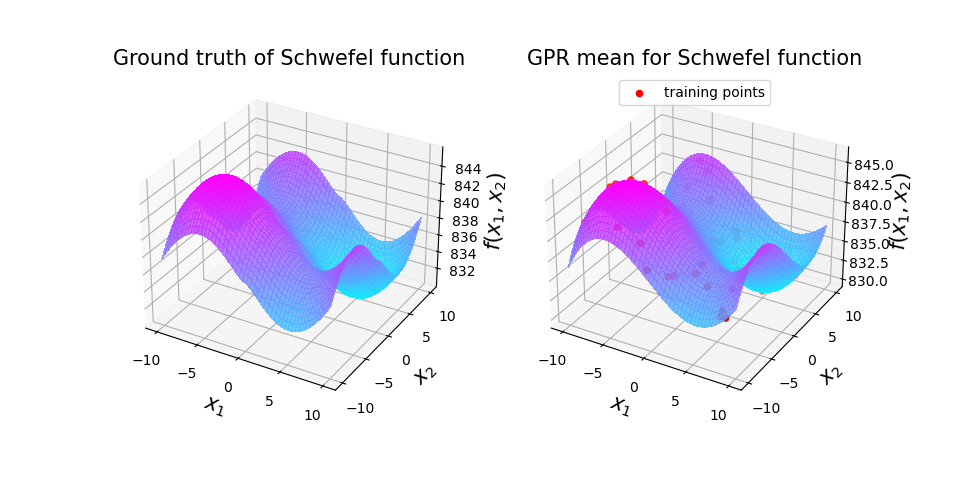

In [16]:
fig3_WRONG # show figure illustrating the issues of not scaling the data appropriately!

This does not look great, especially at the boundary!

<IPython.core.display.Javascript object>


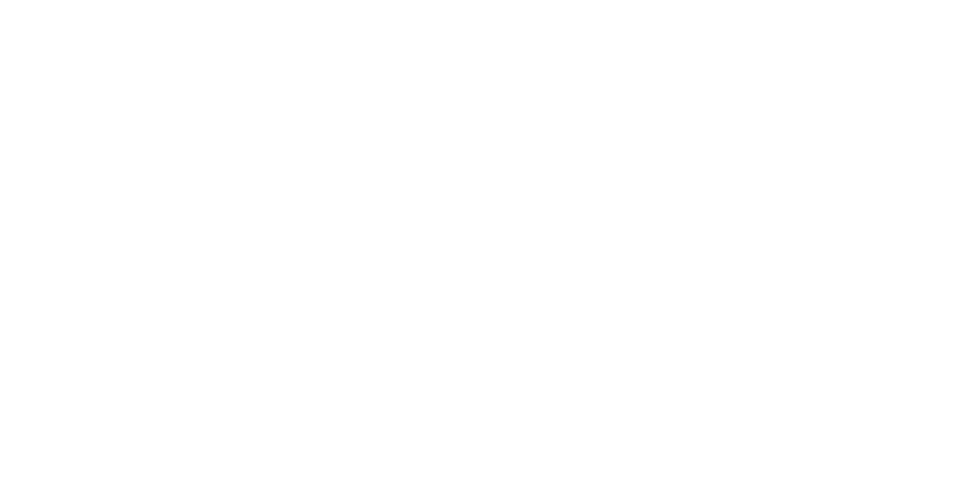

In [17]:
fig4_WRONG = plt.figure(figsize=plt.figaspect(0.5)); ax4_WRONG = []
# Create Contour plot:
ax4_WRONG.append(fig4_WRONG.add_subplot(1, 3, 1))
cset = ax4_WRONG[0].contourf(X1_grid, X2_grid, Y_grid, cmap=set_cm)
ax4_WRONG[0].set_xlabel('$x_1$')
ax4_WRONG[0].set_ylabel('$x_2$')
ax4_WRONG[0].set_title("Ground truth of %s function" % function_name)
fig4_WRONG.colorbar(cset, ax=ax4_WRONG[0])

# Create Contour plot:
ax4_WRONG.append(fig4_WRONG.add_subplot(1, 3, 2))
cset = ax4_WRONG[1].contourf(X1_grid, X2_grid, Y_grid_data_GPpred, cmap=set_cm)
ax4_WRONG[1].set_xlabel('$x_1$')
ax4_WRONG[1].set_ylabel('$x_2$')
ax4_WRONG[1].set_title("GPR mean for %s function" % function_name)
fig4_WRONG.colorbar(cset, ax=ax4_WRONG[1])

# Create Contour plot:
ax4_WRONG.append(fig4_WRONG.add_subplot(1, 3, 3))

SIGMA_grid_data_GPpred = np.reshape(sigma_data_GPpred,np.shape(X1_grid))

cset = ax4_WRONG[2].contourf(X1_grid, X2_grid, SIGMA_grid_data_GPpred, cmap=set_cm)
ax4_WRONG[2].set_xlabel('$x_1$')
ax4_WRONG[2].set_ylabel('$x_2$')
ax4_WRONG[2].set_title("GPR STDV for %s function" % function_name)
fig4_WRONG.colorbar(cset, ax=ax4_WRONG[2])

plt.tight_layout()
plt.close(fig4_WRONG) # close figure to open it in next cell.

<IPython.core.display.Javascript object>


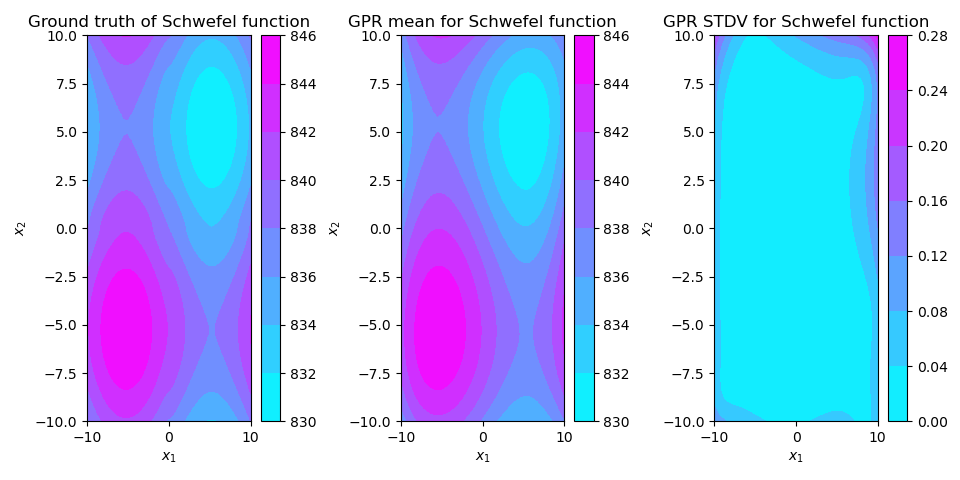

In [18]:
fig4_WRONG # plot the same figure but using countour plots

Now we see clearly that the uncertainty is significant at the boundary!

This happened because the output values are large and we did not **pre-process** the dataset appropriately!

* It is good practice to **scale the dataset**.

Scikit-learn has implemented different [preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html) strategies. **Check the documentation**.

The most common strategy is to standardize the dataset using the StandardScaler:

* StandardScaler: each feature is transformed to have zero-mean and unit standard deviation. In other words, the data becomes normally distributed (it is transformed). **Standardization of datasets is a common requirement for many machine learning models**.

There are other scaling strategies. For example, the simplest one is to use the MinMaxScaler:

* MinMaxScaler: this transformation is simpler, as it just scales the data such that the maximum and minimum value are bounded to specified values (by default between 0 and 1). This keeps the distribution of the data (non distorting), i.e. it **does not** reduce the importance of outliers.

Here's an example of how to scale the $\mathcal{D}_x$ data using the MinMaxScaler (between -1 and 1, instead of between 0 and 1):

``` python
from sklearn.preprocessing import MinMaxScaler
# Scaling inputs with a MinMax Scaler (between -1 and 1):
scaler_x = MinMaxScaler(feature_range=(-1,1))
scaler_x.fit(X_train)
#
X_train_scaled=scaler_x.transform(X_train)
X_test_scaled=scaler_x.transform(X_test)
X_data_scaled=scaler_x.transform(X_data)
````

In [19]:
from sklearn.preprocessing import StandardScaler
# Scaling inputs with a Standard Scaler:
scaler_x = StandardScaler()
scaler_x.fit(X_train) # fit the scaler to the input data
#
X_train_scaled=scaler_x.transform(X_train) # scale the input training data
X_test_scaled=scaler_x.transform(X_test)  # scale the input testing data
X_data_scaled=scaler_x.transform(X_data) # scale the input data (the whole dataset)

idx = 0 # Choose the point you want to check the value (we could also plot the entire dataset.)
print("X_data[%i] is =" % idx, X_data[idx])
print("X_data_scaled[%i] is =" % idx, X_data_scaled[idx])

X_data[0] is = [-10. -10.]
X_data_scaled[0] is = [-1.79658824 -1.50411611]


In [20]:
# Now scaling outputs also using StandardScaler:
y_train = y_train.reshape(-1, 1) # recall that we need to convert the 1D array vector into a 2D array vector
y_test = y_test.reshape(-1, 1)   # recall that we need to convert the 1D array vector into a 2D array vector
y_data = y_data.reshape(-1, 1)   # recall that we need to convert the 1D array vector into a 2D array vector
#
scaler_y = StandardScaler()
scaler_y.fit(y_train) # fit the scaler to the output data
#
y_train_scaled=scaler_y.transform(y_train) # scale the output training data
y_test_scaled=scaler_y.transform(y_test)  # scale the output testing data
y_data_scaled=scaler_y.transform(y_data) # scale the output data (the whole dataset)

idx = 0 # Choose the point you want to check the value (we could also plot the entire dataset.)
print("y_data[%i] is =" % idx, y_data[idx])
print("y_data_scaled[%i] is =" % idx, y_data_scaled[idx])

y_data[0] is = [837.55212937]
y_data_scaled[0] is = [-0.10898576]


In [21]:
# Create the GP model again (same kernel, same parameters and same optimization process!)
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) # This is the standard RBF kernel
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, n_restarts_optimizer=20) # using a small alpha

# The ONLY difference is that we will train the model on SCALED inputs and outputs
gp_model.fit(X_train_scaled, y_train_scaled) # here I am not scaling the target variable; only the features.

# Make the prediction on the entire dataset (for plotting), both for mean and standard deviation
y_data_GPpred_scaled, sigma_data_GPpred_scaled = gp_model.predict(X_data_scaled, return_std=True)
# IMPORTANT: we need to scale the predictions for the mean of the output back to the original scale!
y_data_GPpred = scaler_y.inverse_transform(y_data_GPpred_scaled) # mean
# IMPORTANT: we need to do the same for the standard deviation of the output, but in this case we have to subtract
#            by the mean of the training data because the standard deviation is not transformed by the
#            StandardScaler in the same way as the mean! In the Homework you will derive this...
sigma_data_GPpred = scaler_y.inverse_transform(sigma_data_GPpred_scaled.reshape(-1, 1)) - np.mean(y_train)
my_sigma_data_GPpred = sigma_data_GPpred_scaled.reshape(-1, 1)*np.std(y_train)

# Predict for test set (for error metric)
y_test_GPpred_scaled, sigma_test_GPpred_scaled = gp_model.predict(X_test_scaled, return_std=True)
# Scale mean and std back, as above.
y_test_GPpred = scaler_y.inverse_transform(y_test_GPpred_scaled)
sigma_test_GPpred = scaler_y.inverse_transform(sigma_test_GPpred_scaled.reshape(-1, 1)) - np.mean(y_train)

<IPython.core.display.Javascript object>


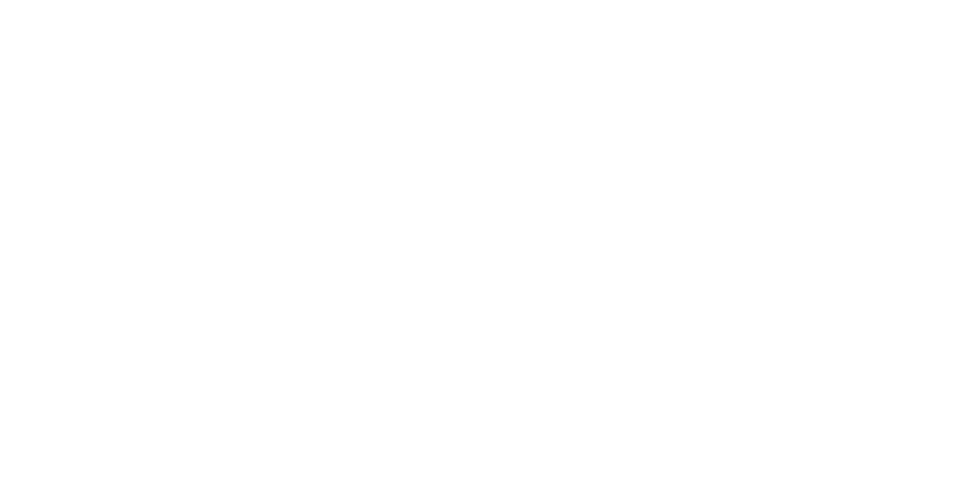

In [22]:
fig3 = plt.figure(figsize=plt.figaspect(0.5)); ax3 = []
# Subplot 1 (left): ground truth
ax3.append(fig3.add_subplot(1, 2, 1, projection='3d'))
surf = ax3[0].plot_surface(X1_grid, X2_grid, Y_grid,
                           cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax3[0].set_xlabel('$x_1$', fontsize=15)
ax3[0].set_ylabel('$x_2$', fontsize=15)
ax3[0].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax3[0].set_title("Ground truth of %s function" % function_name, fontsize=15)

# Subplot 2 (right): GPR approximation
ax3.append(fig3.add_subplot(1, 2, 2, projection='3d'))
Y_grid_data_GPpred = np.reshape(y_data_GPpred,np.shape(X1_grid)) # convert targets into grid format for plotting
surf = ax3[1].plot_surface(X1_grid, X2_grid, Y_grid_data_GPpred,
                                       cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax3[1].set_xlabel('$x_1$', fontsize=15)
ax3[1].set_ylabel('$x_2$', fontsize=15)
ax3[1].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax3[1].set_title("GPR mean for %s function" % function_name, fontsize=15)
ax3[1].scatter(X_train[:,0], X_train[:,1], y_train, marker='o', color='red', label="training points")
ax3[1].legend(loc='upper center')
#plt.tight_layout()
plt.close(fig3) # close figure to open it in next cell.

<IPython.core.display.Javascript object>


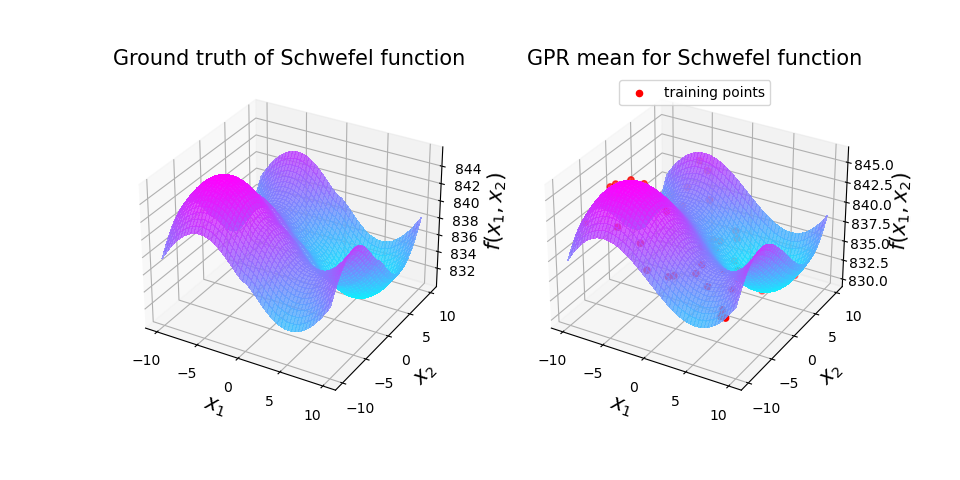

In [23]:
fig3

We can also plot this information via contour plots, and show not only the mean predicted by GPR but also the standard deviation.

Note: you can also overlay the 95% confidence intervals in a surface plot, but usually it becomes really cluttered (so we didn't do it).

<IPython.core.display.Javascript object>


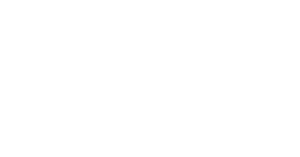

In [24]:
fig4 = plt.figure(figsize=plt.figaspect(0.5)); ax4 = []
# Create Contour plot:
ax4.append(fig4.add_subplot(1, 3, 1))
cset = ax4[0].contourf(X1_grid, X2_grid, Y_grid, cmap=set_cm)
ax4[0].set_xlabel('$x_1$')
ax4[0].set_ylabel('$x_2$')
ax4[0].set_title("Ground truth of %s function" % function_name)
fig4.colorbar(cset, ax=ax4[0])

# Create Contour plot:
ax4.append(fig4.add_subplot(1, 3, 2))
cset = ax4[1].contourf(X1_grid, X2_grid, Y_grid_data_GPpred, cmap=set_cm)
ax4[1].set_xlabel('$x_1$')
ax4[1].set_ylabel('$x_2$')
ax4[1].set_title("GPR mean for %s function" % function_name)
fig4.colorbar(cset, ax=ax4[1])

# Create Contour plot:
ax4.append(fig4.add_subplot(1, 3, 3))

SIGMA_grid_data_GPpred = np.reshape(sigma_data_GPpred,np.shape(X1_grid))

cset = ax4[2].contourf(X1_grid, X2_grid, SIGMA_grid_data_GPpred, cmap=set_cm)
ax4[2].set_xlabel('$x_1$')
ax4[2].set_ylabel('$x_2$')
ax4[2].set_title("GPR STDV for %s function" % function_name)
fig4.colorbar(cset, ax=ax4[2])

plt.tight_layout()
plt.close(fig4) # close figure to open it in next cell.

<IPython.core.display.Javascript object>


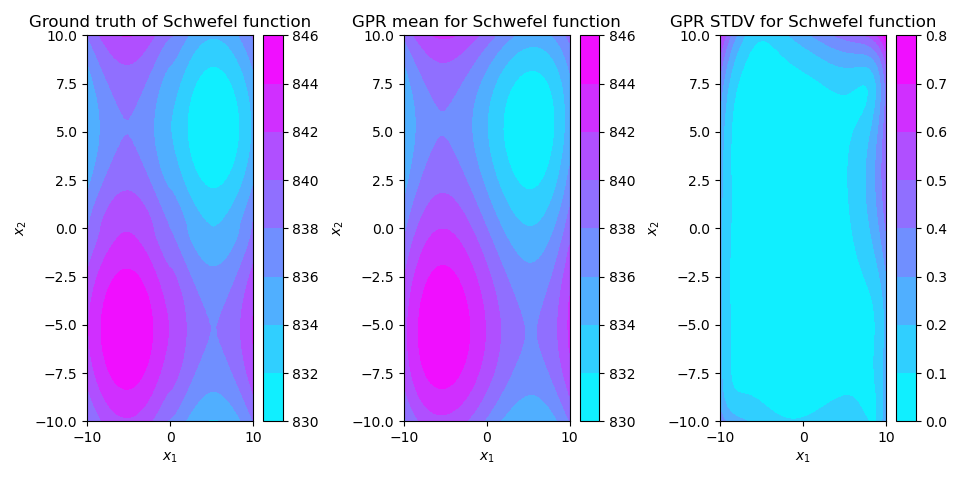

In [25]:
fig4 # show same results but using contour plots.

It's quite remarkable that GPR predicts this function almost perfectly while using only 50 points! This is equivalent to using just $\sqrt{50}\approx 7$ points per dimension!

Let's now compute the $R^2$ error metric for the GPR approximation.

In [26]:
from sklearn.metrics import r2_score # Import error metrics

# Compute MSE and R2 for the GP model
gp_r2_value = r2_score(y_test, y_test_GPpred)

print('R2 score for GPR = ', gp_r2_value)

R2 score for GPR =  0.9956601182570934


#### An important issue in Gaussian processes: lack of scalability

* Redo the GP regression of the Schwefel function but now using 75% of the data for training.

The notes below show the complete code. You probably noticed it took a while to train the GP...

Unfortunately, it is not uncommon for a Machine Learning problem to have millions of data points... But GPs cannot deal with this because the computational cost scales cubically with the number of datapoints: $\mathcal{O}(n^3)$.

The reason for this issue comes from the need to invert the covariance matrix, which is a $n\times n$ matrix where $n$ is the number of training points.

* **To keep in mind**: Gaussian processes are very powerful for small datasets, but they do not scale well for large datasets.

#### Experimenting with GPs to confirm the scalability issue.

Let's try to train the GP using more data. For example, we can to go to this [cell](##split_dataset) and change the testset_ratio to 25% and then run the remaining cells to train the GP and plot the surface to compare with the Ground truth.

Depending on the computer you are using, this can take a while (if your computer can handle it, then keep increasing the number of points per dimension: for example use 100 instead of the 50 we used in this [cell](##create_dataset))...

This scalability issue is **a big limitation** associated to GPs. There are a few modifications one can do to the method, e.g. creating a sparse version, but they still do not scale as well as Artificial Neural Networks.

``` python
# CODE TO ILLUSTRATE THE LACK OF SCALABILITY OF GPR
# Create dataset
n_points_per_dimension = 50 # if your computer can still handle this amount of data, increase this number.
x1 = np.linspace(-10.0, 10.0, n_points_per_dimension)
x2 = np.linspace(-10.0, 10.0, n_points_per_dimension)
X1_grid, X2_grid = np.meshgrid(x1, x2) # creates a grid of points that is necessary to plot surfaces
X_data = np.array([X1_grid, X2_grid]).reshape(2, -1).T
y_data, function_name = schwefel(X_data) # calculate the output of the Schwefel function

scaler_x = StandardScaler()
scaler_x.fit(X_train) # fit the scaler to the input data
X_train_scaled=scaler_x.transform(X_train) # scale the input training data
X_test_scaled=scaler_x.transform(X_test)  # scale the input testing data
X_data_scaled=scaler_x.transform(X_data) # scale the input data (the whole dataset)
#
y_train = y_train.reshape(-1, 1) # recall that we need to convert the 1D array vector into a 2D array vector
y_test = y_test.reshape(-1, 1)   # recall that we need to convert the 1D array vector into a 2D array vector
y_data = y_data.reshape(-1, 1)   # recall that we need to convert the 1D array vector into a 2D array vector
scaler_y = StandardScaler()
scaler_y.fit(y_train) # fit the scaler to the output data
#
y_train_scaled=scaler_y.transform(y_train) # scale the output training data
y_test_scaled=scaler_y.transform(y_test)  # scale the output testing data
y_data_scaled=scaler_y.transform(y_data) # scale the output data (the whole dataset)

# Reshape output data for use in Surface plot:
Y_grid = np.reshape(y_data,np.shape(X1_grid))

# Split dataset into training and testing
testset_ratio = 0.25 # ratio of test set points from the dataset
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size=testset_ratio,random_state=seed)

# The remaining code is the same as in the Lecture (with scaling for the entire dataset).
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, n_restarts_optimizer=20)

# The ONLY difference is that we will train the model on SCALED inputs (not outputs)
gp_model.fit(X_train_scaled, y_train_scaled) # here I am not scaling the target variable; only the features.

# Make the prediction on the entire dataset (for plotting)
y_data_GPpred_scaled = gp_model.predict(X_data_scaled) # NOTE THAT THE MODEL OUTPUTS ARE SCALED
y_data_GPpred = scaler_y.inverse_transform(y_data_GPpred_scaled)

# Plot figure comparing ground truth and GPR prediction (where we only scaled the inputs)
fig = plt.figure(figsize=plt.figaspect(0.5)); ax = []
# Grround truth
ax.append(fig.add_subplot(1, 2, 1, projection='3d'))
surf = ax[0].plot_surface(X1_grid, X2_grid, Y_grid,
                          cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax[0].set_xlabel('$x_1$', fontsize=15)
ax[0].set_ylabel('$x_2$', fontsize=15)
ax[0].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax[0].set_title("Ground truth of %s function" % function_name, fontsize=15)

# GPR approximation (where we only scaled the inputs)
ax.append(fig.add_subplot(1, 2, 2, projection='3d'))
Y_grid_data_GPpred = np.reshape(y_data_GPpred,np.shape(X1_grid)) # convert targets into grid format for plotting
surf = ax[1].plot_surface(X1_grid, X2_grid, Y_grid_data_GPpred,
                              cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax[1].set_xlabel('$x_1$', fontsize=15)
ax[1].set_ylabel('$x_2$', fontsize=15)
ax[1].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax[1].set_title("GPR mean for %s function" % function_name, fontsize=15)
ax[1].scatter(X_train[:,0], X_train[:,1], y_train,
                  marker='o', color='red', label="training points")
ax[1].legend(loc='upper center')
```

# <font color='red'>HOMEWORK</font>

Redo the Gaussian Processes Regression (GPR) of the Schwefel function for these conditions:
1. Training for data where you only scale the **inputs** using the StandardScaler. You get the same warning message (convergence difficulties to find the parameters of the kernel). **Why?**
    
2. Training for data where you only scale the **outputs** before training. This time your predictions are as good as the ones obtained when scaling both the inputs and the outputs. **Why?**
    
3. Create your own StandardScaler class achieving the same as scikit-learn's StandardScaler, but where the inverse_transform for the standard deviation does not need to be corrected like we did in the Lecture.

## 1.2. Multidimensional regression with Artificial Neural Networks

As we discovered previously for the one-dimensional example, ANNs behave in a somewhat opposite way: training for data scarce problems can be challenging, but ANNs are very scalable for "big data" problems.

Below is a code including an option to perform grid search (or not). The code is basically the same as what we saw in Lecture 10 but now with 2D features.

In [27]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam # import the optimizer you want to use to calculate the parameters
from keras.models import Sequential # to create a feedforward neural network
from keras.layers.core import Dense # to create a feedforward neural network with dense layers
from keras.wrappers.scikit_learn import KerasRegressor # a new version will use scikeras
from keras.callbacks import EarlyStopping # a strategy for complexity control
from sklearn.model_selection import GridSearchCV # simple (brute force) approach to find better hyperparameters.
#
# Function to create the ANN model
def create_ANN(input_dimensions=1,neurons1=10,neurons2=10,neurons3=10,neurons4=10,activation='relu',optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(neurons1, input_dim=input_dimensions, activation=activation)) # first hidden layer
    model.add(Dense(neurons2, activation=activation)) # second hidden layer
    #model.add(Dense(neurons3, activation=activation)) # thrid hidden layer
    #model.add(Dense(neurons4, activation=activation)) # fourth hidden layer, etc.
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=optimizer)
    return model
#
# Do you want to look for the best parameters for the Neural Network using Grid Search ("brute force")?
gridsearch = 0 # If gridsearch = 1 it can be quite slow!

if gridsearch==1:
    # If you don't want to use Early Stopping, then comment the command below.
    early_stopping = EarlyStopping(monitor='val_loss', # use validation error to check if training should stop early
                                   min_delta=0.0, # minimum change in the monitored quantity to qualify as an
                                                  # improvement (if 0, then even small improvements count)
                                   patience=30, # be patient for a few epochs to verify evolution of loss
                                   mode='min') # in min mode, training stops when val_loss stops decreasing
    # Summary of this early_stopping criterion:
    # stop training when there is no improvement in the loss for 30 consecutive epochs.
    #
    # Define the grid search for hyperparameters. Each veriable is a 1D array whose elements represent a particular
    # choice of value for that hyperparameter. The grid search will then create all possible combinations among
    # the hyperparameters values that are defined below. If you do not want to change the value of a particular
    # hyperparameter you can define a 1D array that only has 1 element.
    neurons1 = [5,20,200] # number of neurons in hidden layer 1
    neurons2 = [5,10] # number of neurons in hidden layer 2 (if present; uncomment in create_ANN function)
    neurons3 = [10] # number of neurons in hidden layer 3 (if present; uncomment in create_ANN function)
    neurons4 = [10] # number of neurons in hidden layer 4 (if present; uncomment in create_ANN function)
    batch_size = [len(X_train)] # number of samples in each batch
    epochs = [1000] # each element in the vector contains the number of epochs that each model should use.
    optimizer = ['adam'] # 
#    optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'] # different optimizers
#    init_mode = ['uniform', 'lecun_uniform', 'normal', 'orthogonal', 'zero', 'one', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'] # different weight initialization strategies
    #
    param_grid = dict(batch_size=batch_size, # define the number of samples in each batch
                      epochs=epochs, # total number of epochs
                      neurons1=neurons1, # number of neurons in the first hidden layer
                      neurons2=neurons2, # number of neurons in the second hidden layer
                      #neurons3=neurons3,neurons4=neurons4, # commented out because I am not using them
                      optimizer=optimizer) # optimizer to find the model parameters
    ANN_model = KerasRegressor(build_fn=create_ANN, # the function where we define our ANN
                               input_dimensions=np.shape(X_train)[1]) # the input dimensions (here it is 2)
    grid = GridSearchCV(estimator=ANN_model, # use our ANN regression model
                        param_grid=param_grid, # use a grid of hyperparameters to find the best among the grid.
                        n_jobs=-1, # number of CPUs to use (if n_jobs = -1 then it uses all CPUs)
                        cv=3) # Using cross validation (if cv=3 then uses 3-fold cross validation)
    grid_result = grid.fit(X_train_scaled, y_train_scaled, # training data
                           callbacks=[early_stopping], # include early stopping
                           validation_data=(X_test_scaled, y_test_scaled)) # validation data to compute loss
    # Once every model in the Grid of hyperparameters is trained, then pick the best model and fit it to
    # the entire training set (without considering cross validation, as we did in the grid search).
    history = grid_result.best_estimator_.fit(X_train_scaled, y_train, 
                                              callbacks=[early_stopping],
                                              validation_data=(X_test_scaled,
                                                               y_test_scaled))
    # Summarize results
    print("Best: %f using %s" % (grid_result.best_score_,
                                 grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score'] # mean of the error metric for each Grid point
    stds = grid_result.cv_results_['std_test_score']   # std of the error metric for each Grid point
    params = grid_result.cv_results_['params'] # hyperparameters used in each Grid point
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param)) # print all the hyperparameters used in each Grid point
else: # just use a particular Neural Network of choice
    # If you don't want to use Early Stopping, then comment the command below.
    early_stopping = EarlyStopping(monitor='val_loss', # use validation error to check if training should stop early
                                   min_delta=0.0, # minimum change in the monitored quantity to qualify as an
                                                  # improvement (if 0, then even small improvements count)
                                   patience=30, # be patient for a few epochs to verify evolution of loss
                                   mode='min') # in min mode, training stops when val_loss stops decreasing
    # Summary of this early_stopping criterion:
    # stop training when there is no improvement in the loss for 30 consecutive epochs.
    
    neurons1=200 # number of neurons in hidden layer 1
    neurons2=10  # number of neurons in hidden layer 2
    epochs = 1000 # number of epochs
    batch_size = len(X_train) # number of samples in each batch
    optimizer = 'adam' # optimizer
    ANN_model = KerasRegressor(build_fn=create_ANN, # the function where we define our ANN
                               input_dimensions=np.shape(X_train)[1], # the input dimensions (here it is 2)
                               neurons1=neurons1, # number of neurons in the first hidden layer
                               neurons2=neurons2, # number of neurons in the second hidden layer
                               batch_size=batch_size, # define the number of samples in each batch
                               epochs=epochs, # number of epochs
                               optimizer=optimizer, # optimizer
                               callbacks=[early_stopping], # include early stopping
                               validation_data=(X_test_scaled, y_test_scaled)) # validation data to compute loss
    # Train the model:
    history = ANN_model.fit(X_train_scaled, y_train_scaled)

/tmp/ipykernel_25922/706596239.py:92: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  ANN_model = KerasRegressor(build_fn=create_ANN, # the function where we define our ANN
2022-03-17 11:13:54.159246: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-17 11:13:54.669294: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2967 MB memory:  -> device: 0, name: Quadro M2000, pci bus id: 0000:03:00.0, compute capability: 5.2


Epoch 1/1000
1/1 [==============================] - 1s 742ms/step - loss: 0.9971 - val_loss: 0.9325
Epoch 2/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.9484 - val_loss: 0.8885
Epoch 3/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.9027 - val_loss: 0.8479
Epoch 4/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.8624 - val_loss: 0.8113
Epoch 5/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.8255 - val_loss: 0.7789
Epoch 6/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.7928 - val_loss: 0.7487
Epoch 7/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.7621 - val_loss: 0.7212
Epoch 8/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.7336 - val_loss: 0.6970
Epoch 9/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.7075 - val_loss: 0.6744
Epoch 10/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.6832 - val_loss: 0.6527
Epoch 11

1/1 [==============================] - 0s 71ms/step - loss: 0.1714 - val_loss: 0.3297
Epoch 84/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.1698 - val_loss: 0.3288
Epoch 85/1000
1/1 [==============================] - 0s 68ms/step - loss: 0.1683 - val_loss: 0.3279
Epoch 86/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.1669 - val_loss: 0.3269
Epoch 87/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.1655 - val_loss: 0.3259
Epoch 88/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.1641 - val_loss: 0.3250
Epoch 89/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.1627 - val_loss: 0.3240
Epoch 90/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.1614 - val_loss: 0.3230
Epoch 91/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.1601 - val_loss: 0.3221
Epoch 92/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.1587 - val_loss: 0.3212
Epoch 93/1000


1/1 [==============================] - 0s 74ms/step - loss: 0.0333 - val_loss: 0.1518
Epoch 246/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0329 - val_loss: 0.1509
Epoch 247/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0326 - val_loss: 0.1500
Epoch 248/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0322 - val_loss: 0.1491
Epoch 249/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.0319 - val_loss: 0.1482
Epoch 250/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0316 - val_loss: 0.1473
Epoch 251/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0312 - val_loss: 0.1464
Epoch 252/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.0309 - val_loss: 0.1455
Epoch 253/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.0306 - val_loss: 0.1446
Epoch 254/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.0303 - val_loss: 0.1438
Epoch

1/1 [==============================] - 0s 71ms/step - loss: 0.0079 - val_loss: 0.0665
Epoch 408/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0079 - val_loss: 0.0662
Epoch 409/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.0078 - val_loss: 0.0660
Epoch 410/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0078 - val_loss: 0.0657
Epoch 411/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0077 - val_loss: 0.0654
Epoch 412/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.0076 - val_loss: 0.0651
Epoch 413/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.0076 - val_loss: 0.0649
Epoch 414/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.0075 - val_loss: 0.0646
Epoch 415/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0075 - val_loss: 0.0643
Epoch 416/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.0074 - val_loss: 0.0641
Epoch

1/1 [==============================] - 0s 72ms/step - loss: 0.0024 - val_loss: 0.0370
Epoch 570/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0024 - val_loss: 0.0369
Epoch 571/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.0023 - val_loss: 0.0368
Epoch 572/1000
1/1 [==============================] - 0s 79ms/step - loss: 0.0023 - val_loss: 0.0368
Epoch 573/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.0023 - val_loss: 0.0367
Epoch 574/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.0023 - val_loss: 0.0366
Epoch 575/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0023 - val_loss: 0.0365
Epoch 576/1000
1/1 [==============================] - 0s 68ms/step - loss: 0.0023 - val_loss: 0.0363
Epoch 577/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0022 - val_loss: 0.0362
Epoch 578/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0022 - val_loss: 0.0361
Epoch

1/1 [==============================] - 0s 73ms/step - loss: 7.1368e-04 - val_loss: 0.0260
Epoch 730/1000
1/1 [==============================] - 0s 72ms/step - loss: 7.0924e-04 - val_loss: 0.0259
Epoch 731/1000
1/1 [==============================] - 0s 74ms/step - loss: 7.0510e-04 - val_loss: 0.0258
Epoch 732/1000
1/1 [==============================] - 0s 69ms/step - loss: 7.0085e-04 - val_loss: 0.0258
Epoch 733/1000
1/1 [==============================] - 0s 76ms/step - loss: 6.9684e-04 - val_loss: 0.0258
Epoch 734/1000
1/1 [==============================] - 0s 70ms/step - loss: 6.9272e-04 - val_loss: 0.0257
Epoch 735/1000
1/1 [==============================] - 0s 73ms/step - loss: 6.8844e-04 - val_loss: 0.0257
Epoch 736/1000
1/1 [==============================] - 0s 77ms/step - loss: 6.8430e-04 - val_loss: 0.0257
Epoch 737/1000
1/1 [==============================] - 0s 75ms/step - loss: 6.8041e-04 - val_loss: 0.0256
Epoch 738/1000
1/1 [==============================] - 0s 67ms/step - l

1/1 [==============================] - 0s 77ms/step - loss: 3.2623e-04 - val_loss: 0.0221
Epoch 886/1000
1/1 [==============================] - 0s 72ms/step - loss: 3.2485e-04 - val_loss: 0.0221
Epoch 887/1000
1/1 [==============================] - 0s 71ms/step - loss: 3.2354e-04 - val_loss: 0.0220
Epoch 888/1000
1/1 [==============================] - 0s 68ms/step - loss: 3.2220e-04 - val_loss: 0.0220
Epoch 889/1000
1/1 [==============================] - 0s 72ms/step - loss: 3.2081e-04 - val_loss: 0.0220
Epoch 890/1000
1/1 [==============================] - 0s 73ms/step - loss: 3.1954e-04 - val_loss: 0.0220
Epoch 891/1000
1/1 [==============================] - 0s 72ms/step - loss: 3.1819e-04 - val_loss: 0.0220
Epoch 892/1000
1/1 [==============================] - 0s 74ms/step - loss: 3.1680e-04 - val_loss: 0.0219
Epoch 893/1000
1/1 [==============================] - 0s 71ms/step - loss: 3.1573e-04 - val_loss: 0.0219
Epoch 894/1000
1/1 [==============================] - 0s 71ms/step - l

Let's plot the result for ANN as we did for GPR.

<IPython.core.display.Javascript object>


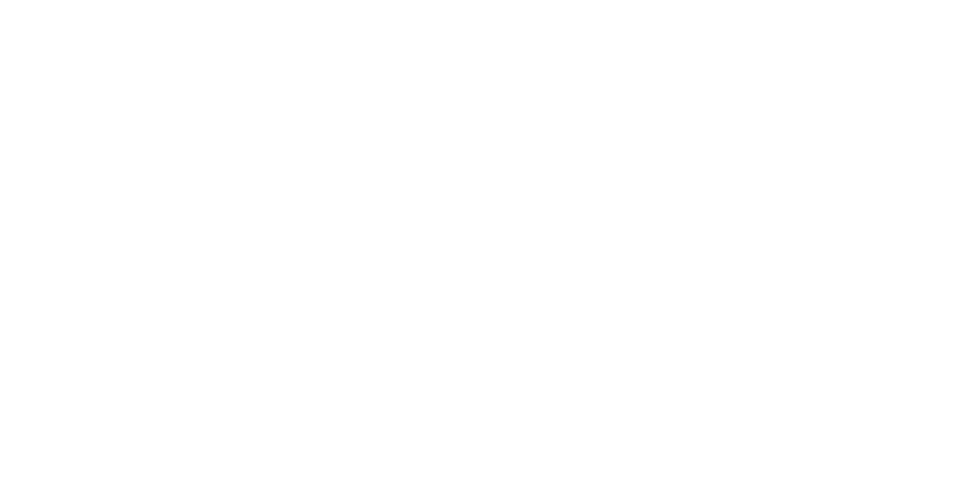

In [28]:
fig5 = plt.figure(figsize=plt.figaspect(0.5)); ax5 = []
#
# Subplot 1 (left): ground truth
ax5.append(fig5.add_subplot(1, 2, 1, projection='3d'))
surf = ax5[0].plot_surface(X1_grid, X2_grid, Y_grid,
                           cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax5[0].set_xlabel('$x_1$')
ax5[0].set_ylabel('$x_2$')
ax5[0].set_zlabel('$f(x_1,x_2)$')
ax5[0].set_title("Ground truth of %s function" % function_name)

# Subplot 2 (right): ANN prediction 
ax5.append(fig5.add_subplot(1, 2, 2, projection='3d'))
y_data_ANNpred_scaled = history.model.predict(X_data_scaled)
y_data_ANNpred = scaler_y.inverse_transform(y_data_ANNpred_scaled) # scale predictions back to original scale
Y_grid_data_ANNpred = np.reshape(y_data_ANNpred, np.shape(X1_grid)) # putting targets in grid format for plotting
surf = ax5[1].plot_surface(X1_grid, X2_grid, Y_grid_data_ANNpred,
                           cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax5[1].set_xlabel('$x_1$', fontsize=15)
ax5[1].set_ylabel('$x_2$', fontsize=15)
ax5[1].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax5[1].set_title("ANN approximation of %s function" % function_name, fontsize=15)
ax5[1].scatter(X_train[:,0], X_train[:,1], y_train, marker='o', color='red', label="training points")
ax5[1].legend(loc='lower left', fontsize=15)
#
plt.tight_layout()
plt.close(fig5)

<IPython.core.display.Javascript object>


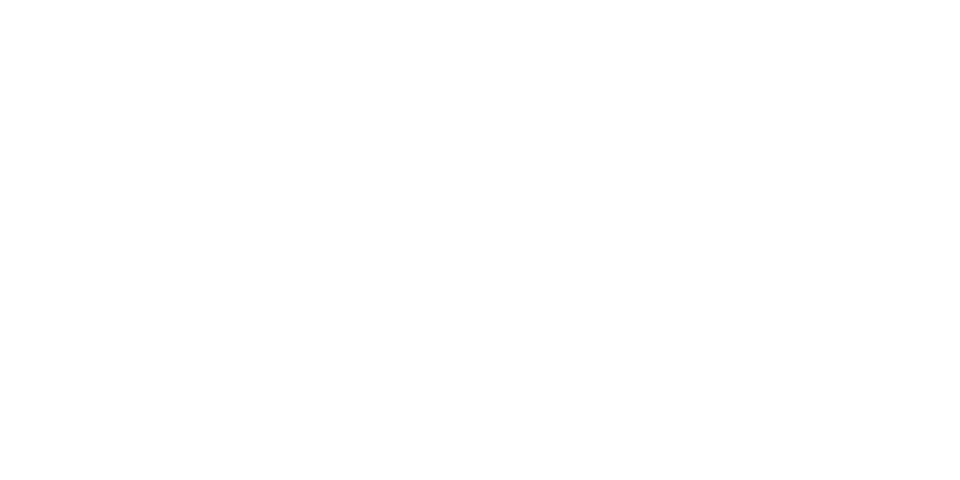

In [29]:
fig5 # surface plots for ANN

The approximation does not seem too bad (and it can get a lot better!).

* However, it can be challenging to make ANNs as good as GPR for a small number of training points (and there is a theoretical result that explains why!).

Finally, let's calculate the R2 score for the ANN.

In [31]:
# Compute R2 for the ANN model

y_test_ANNpred_scaled = history.model.predict(X_test_scaled)
y_test_ANNpred = scaler_y.inverse_transform(y_test_ANNpred_scaled) # scale predictions back to original scale

ANN_r2_value = r2_score(y_test, y_test_ANNpred)

print('R2 score for ANN = ', ANN_r2_value)

R2 score for ANN =  0.9794280769216785


Try training GPR and ANN using different split ratio for training and testing data!

* Click [here](##split_dataset) to go to the cell where data was split.

## 1.3. GPR and ANN with noisy datasets

Due to time constraints, I won't do with you the same cases when considering a noisy dataset...

But I am including the codes here and we can take a look at the results.

In [32]:
# Create the noisy dataset:
random_std = 0.05+0.1*np.random.random(y_data.shape)
max_diff = np.max(y_data)-np.min(y_data) # magnitude of signal
noise_data = np.random.normal(0,random_std)*max_diff
y_noisy_data = y_data + noise_data # Perturb every y_data point with Gaussian noise

# Pair up points with their associated noise level (because of train_test_split):
Y_noisy_data = np.column_stack((y_noisy_data,noise_data))

# Split into 10% training points and the rest for testing:
X_train, X_test, Y_noisy_train, Y_noisy_test = train_test_split(X_data,
                                    Y_noisy_data, test_size=testset_ratio,
                                    random_state=seed) # "noisy_train" is a great name for a variable, hein?

y_noisy_train = Y_noisy_train[:,0]
noise_train = Y_noisy_train[:,1]
y_noisy_test = Y_noisy_test[:,0]
noise_test = Y_noisy_test[:,1]

# Scaling inputs with a Standard Scaler:
scaler_x = StandardScaler()
scaler_x.fit(X_train)
#
X_train_scaled=scaler_x.transform(X_train)
X_test_scaled=scaler_x.transform(X_test)
X_data_scaled=scaler_x.transform(X_data)

# Scaling outputs with a Standard Scaler:
y_noisy_train = y_noisy_train.reshape(-1, 1)
y_noisy_test = y_noisy_test.reshape(-1, 1)
y_noisy_data = y_noisy_data.reshape(-1, 1)
#
scaler_y = StandardScaler()
scaler_y.fit(y_noisy_train)
#
y_noisy_train_scaled=scaler_y.transform(y_noisy_train)
y_noisy_test_scaled=scaler_y.transform(y_noisy_test)
y_noisy_data_scaled=scaler_y.transform(y_noisy_data)

In [33]:
# GPR
# Define the kernel function
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) # This is the standard RBF kernel
#kernel = 1.0 * RBF(10, (1e-2, 1e2)) # Same kernel as above
                                    #(scikit-learn assumes constant
                                    # variance if you just write RBF
                                    # without the constant kernel or
                                    # without multiplying by 1.0)

# Other examples of kernels:
#kernel = ExpSineSquared(length_scale=3.0, periodicity=3.14,
#                       length_scale_bounds=(0.1, 10.0),
#                       periodicity_bounds=(0.1, 10)) * RBF(3.0, (1e-2, 1e2))
#kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2),nu=1.5)
                
gp_model = GaussianProcessRegressor(kernel=kernel,
                                    alpha=noise_train.ravel()**2, # include noise level at each training point
                                    n_restarts_optimizer=20)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp_model.fit(X_train, y_noisy_train)

# Make the prediction on the entire dataset (for plotting)
y_noisy_data_GPpred, sigma_noisy_data_GPpred = gp_model.predict(X_data, return_std=True)

# Predict for test set (for error metric)
y_noisy_test_GPpred, sigma_noisy_test_GPpred = gp_model.predict(X_test, return_std=True)

/home/mabessa/miniconda3/envs/3dasm/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/mabessa/miniconda3/envs/3dasm/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


<IPython.core.display.Javascript object>


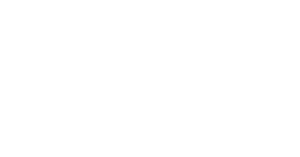

In [34]:
fig6 = plt.figure(figsize=plt.figaspect(0.5)); ax6 = []
ax6.append(fig6.add_subplot(1, 2, 1, projection='3d'))
surf = ax6[0].plot_surface(X1_grid, X2_grid, Y_grid,
                           cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax6[0].set_xlabel('$x_1$')
ax6[0].set_ylabel('$x_2$')
ax6[0].set_zlabel('$f(x_1,x_2)$')
ax6[0].set_title("Ground truth of %s function" % function_name)
ax6[0].scatter(X_train[:,0], X_train[:,1], y_noisy_train,
            marker='o', color='red',
           label="training points")
ax6[0].legend(loc='lower left')

# Subplot 2
ax6.append(fig6.add_subplot(1, 2, 2, projection='3d'))
Y_grid_noisy_data_GPpred = np.reshape(y_noisy_data_GPpred, np.shape(X1_grid))
surf = ax6[1].plot_surface(X1_grid, X2_grid, Y_grid_noisy_data_GPpred,
                           cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax6[1].set_xlabel('$x_1$')
ax6[1].set_ylabel('$x_2$')
ax6[1].set_zlabel('$f(x_1,x_2)$')
ax6[1].set_title("GPR mean for %s function" % function_name)
ax6[1].scatter(X_train[:,0], X_train[:,1], y_noisy_train,
            marker='o', color='red', label="training points")
ax6[1].legend(loc='lower left')

plt.tight_layout()
plt.close(fig6)

<IPython.core.display.Javascript object>


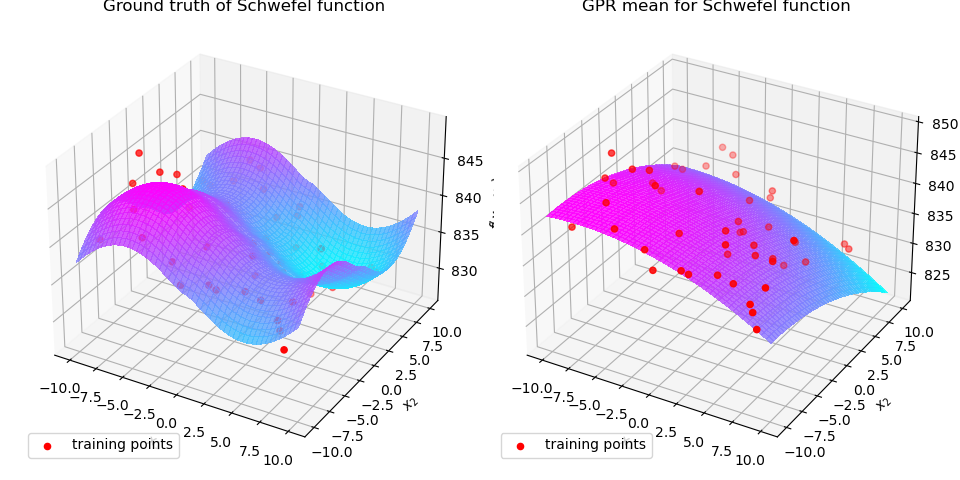

In [35]:
fig6 # plot surfaces

<IPython.core.display.Javascript object>


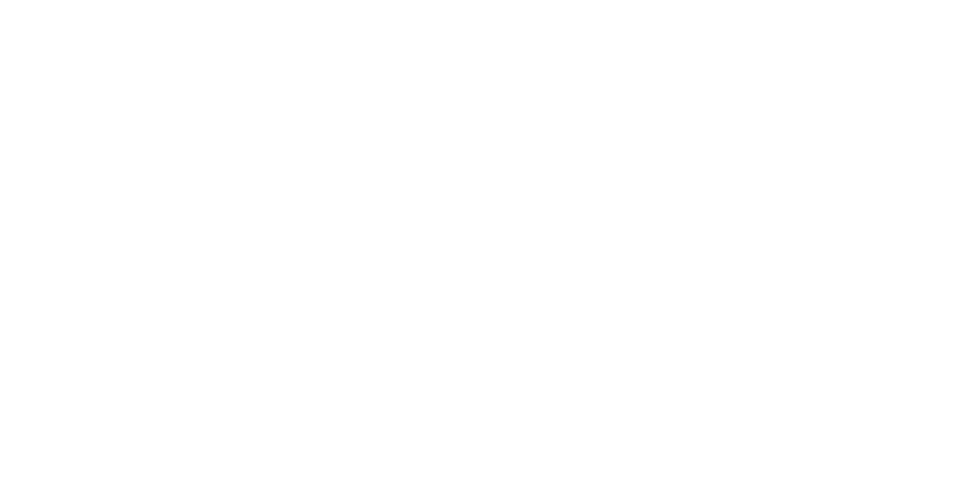

In [36]:
fig7 = plt.figure(figsize=plt.figaspect(0.5)); ax7 = []
# Create Contour plot:
ax7.append(fig7.add_subplot(1, 3, 1))
cset = ax7[0].contourf(X1_grid, X1_grid, Y_grid, cmap=set_cm)
ax7[0].set_xlabel('$x_1$')
ax7[0].set_ylabel('$x_2$')
ax7[0].set_title("Ground truth of %s function" % function_name)
fig7.colorbar(cset, ax=ax7[0])

# Create Contour plot:
ax7.append(fig7.add_subplot(1, 3, 2))
cset = ax7[1].contourf(X1_grid, X2_grid, Y_grid_noisy_data_GPpred,
                       cmap=set_cm)
ax7[1].set_xlabel('$x_1$')
ax7[1].set_ylabel('$x_2$')
ax7[1].set_title("GPR mean for %s function" % function_name)
fig7.colorbar(cset, ax=ax4)

# Create Contour plot:
ax7.append(fig7.add_subplot(1, 3, 3))
SIGMA_grid_noisy_data_GPpred = np.reshape(sigma_noisy_data_GPpred, np.shape(X1_grid))
cset = ax7[2].contourf(X1_grid, X2_grid, SIGMA_grid_noisy_data_GPpred,
                       cmap=set_cm)
ax7[2].set_xlabel('$x_1$')
ax7[2].set_ylabel('$x_2$')
ax7[2].set_title("GPR STDV for %s function" % function_name)
fig7.colorbar(cset, ax=ax7[2])

plt.tight_layout()
plt.close(fig7)

<IPython.core.display.Javascript object>


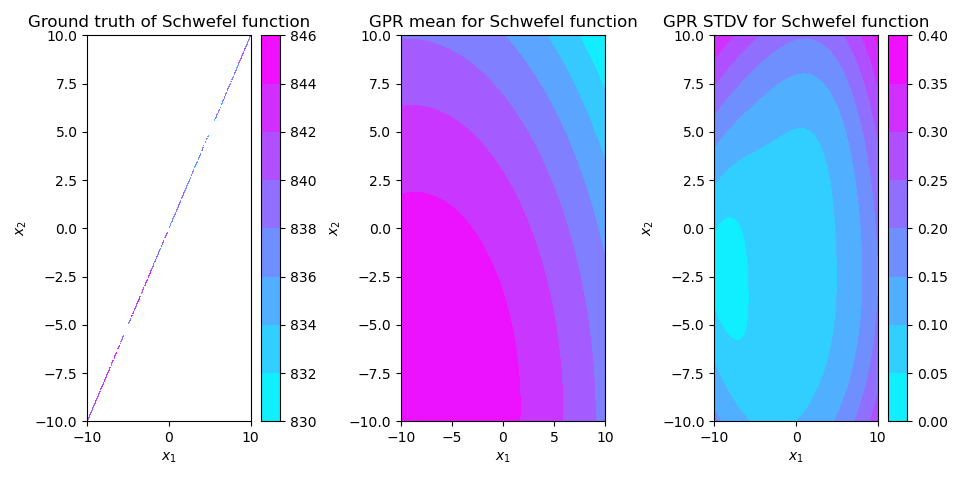

In [37]:
fig7 # plot contours

In [38]:
# Error metric
# Compute R2 for the GP model
gp_noisy_r2_value = r2_score(y_noisy_test, y_noisy_test_GPpred)

print('R2 score for GPR in noisy dataset =', gp_noisy_r2_value)

R2 score for GPR in noisy dataset = 0.17066681803095085


In [39]:
# And now for the ANN:

# Function to create model, required for KerasClassifier when SPECIFYING INPUTS
def create_model(input_dimensions=1,neurons1=10,neurons2=10,neurons3=10,neurons4=10,activation='relu',optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(neurons1, input_dim=input_dimensions, activation=activation)) # first hidden layer
    model.add(Dense(neurons2, activation=activation)) # second hidden layer
    #model.add(Dense(neurons3, activation=activation)) # thrid hidden layer
    #model.add(Dense(neurons4, activation=activation)) # fourth hidden layer, etc.
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=optimizer)
    return model
#
# Do you want to look for the best parameters for the Neural Network?
# (slower)
gridsearch = 0

if gridsearch==1:
    # create model
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=30, mode='min')
#    NN_model = KerasRegressor(build_fn=create_model(input_dimensions=1,neurons=20),
#                              callbacks=[early_stopping], validation_data=(scaler.transform(X_test), y_test))
    # define the grid search parameters
    neurons1 = [5,20,200] # number of neurons in hidden layer 1
    neurons2 = [5,10] # number of neurons in hidden layer 2 (if present; uncomment in create_model function)
    neurons3 = [10] # number of neurons in hidden layer 3 (if present; uncomment in create_model function)
    neurons4 = [10] # number of neurons in hidden layer 4 (if present; uncomment in create_model function)
    #
    batch_size = [len(X_train)]
    #
    epochs = [1000]
    #
    optimizer = ['adam']
#    optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#    init_mode = ['uniform', 'lecun_uniform', 'normal', 'orthogonal', 'zero', 'one', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']    
    #
    param_grid = dict(batch_size=batch_size,
                      epochs=epochs,neurons1=neurons1,
                      neurons2=neurons2,
                      #neurons3=neurons3,neurons4=neurons4, # commented out because I am not using them
                      optimizer=optimizer)
    NN_model = KerasRegressor(build_fn=create_model,
                              input_dimensions=np.shape(X_train)[1])
    grid = GridSearchCV(estimator=NN_model,
                        param_grid=param_grid,
                        n_jobs=1, cv=3, iid=False)
    grid_result = grid.fit(X_train_scaled, y_train,
                           callbacks=[early_stopping],
                           validation_data=(X_test_scaled, y_noisy_test_scaled))
    history = grid_result.best_estimator_.fit(X_train_scaled,
                                              y_train,
                                              callbacks=[early_stopping],
                                              validation_data=(X_test_scaled,
                                                               y_noisy_test_scaled))
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_,
                                 grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
else: # just use a particular Neural Network of choice
    # Define early stopping:
    early_stopping = EarlyStopping(monitor='val_loss',
                                   min_delta=0.0,
                                   patience=30,
                                   mode='min')
    neurons1=200
    neurons2=10
    NN_model = KerasRegressor(build_fn=create_model,
                              input_dimensions=np.shape(X_train)[1],
                              neurons1=neurons1,
                              neurons2=neurons2,
                              batch_size=len(X_train),
                              epochs=1000,
                              optimizer='adam',
                              callbacks=[early_stopping],
                              validation_data=(X_test_scaled,
                                               y_noisy_test_scaled))
    #
    history = NN_model.fit(X_train_scaled, y_noisy_train_scaled)
#    

Epoch 1/1000


/tmp/ipykernel_25922/1324377696.py:72: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  NN_model = KerasRegressor(build_fn=create_model,


1/1 [==============================] - 0s 344ms/step - loss: 1.0216 - val_loss: 0.8486
Epoch 2/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.9898 - val_loss: 0.8219
Epoch 3/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.9602 - val_loss: 0.7960
Epoch 4/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.9325 - val_loss: 0.7717
Epoch 5/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.9060 - val_loss: 0.7508
Epoch 6/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.8833 - val_loss: 0.7320
Epoch 7/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.8625 - val_loss: 0.7144
Epoch 8/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.8429 - val_loss: 0.6994
Epoch 9/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.8260 - val_loss: 0.6862
Epoch 10/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.8110 - val_loss: 0.6727
Epoch 11/1000
1/1 [==

1/1 [==============================] - 0s 70ms/step - loss: 0.3092 - val_loss: 0.4228
Epoch 84/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.3078 - val_loss: 0.4217
Epoch 85/1000
1/1 [==============================] - 0s 68ms/step - loss: 0.3063 - val_loss: 0.4208
Epoch 86/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.3047 - val_loss: 0.4203
Epoch 87/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.3030 - val_loss: 0.4198
Epoch 88/1000
1/1 [==============================] - 0s 66ms/step - loss: 0.3012 - val_loss: 0.4197
Epoch 89/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.2996 - val_loss: 0.4197
Epoch 90/1000
1/1 [==============================] - 0s 65ms/step - loss: 0.2980 - val_loss: 0.4199
Epoch 91/1000
1/1 [==============================] - 0s 68ms/step - loss: 0.2966 - val_loss: 0.4202
Epoch 92/1000
1/1 [==============================] - 0s 64ms/step - loss: 0.2951 - val_loss: 0.4206
Epoch 93/1000


1/1 [==============================] - 0s 66ms/step - loss: 0.1315 - val_loss: 0.2696
Epoch 246/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.1310 - val_loss: 0.2689
Epoch 247/1000
1/1 [==============================] - 0s 66ms/step - loss: 0.1304 - val_loss: 0.2682
Epoch 248/1000
1/1 [==============================] - 0s 68ms/step - loss: 0.1298 - val_loss: 0.2677
Epoch 249/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.1293 - val_loss: 0.2673
Epoch 250/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.1287 - val_loss: 0.2668
Epoch 251/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.1282 - val_loss: 0.2662
Epoch 252/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.1276 - val_loss: 0.2654
Epoch 253/1000
1/1 [==============================] - 0s 64ms/step - loss: 0.1271 - val_loss: 0.2646
Epoch 254/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.1265 - val_loss: 0.2639
Epoch

1/1 [==============================] - 0s 74ms/step - loss: 0.0802 - val_loss: 0.2184
Epoch 408/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0800 - val_loss: 0.2180
Epoch 409/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0799 - val_loss: 0.2179
Epoch 410/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0797 - val_loss: 0.2180
Epoch 411/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0795 - val_loss: 0.2181
Epoch 412/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0794 - val_loss: 0.2182
Epoch 413/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0792 - val_loss: 0.2182
Epoch 414/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0790 - val_loss: 0.2181
Epoch 415/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0789 - val_loss: 0.2179
Epoch 416/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0787 - val_loss: 0.2178
Epoch

<IPython.core.display.Javascript object>


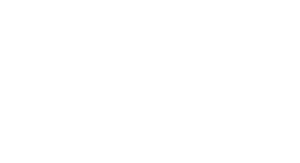

In [40]:
fig8 = plt.figure(figsize=plt.figaspect(0.5)); ax8 = []
#
# Subplot 1 (top) of Figure 1: ground truth
ax8.append(fig8.add_subplot(1, 2, 1, projection='3d'))
surf = ax8[0].plot_surface(X1_grid, X2_grid, Y_grid,
                       cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
#
# Create axis labels and title:
ax8[0].set_xlabel('$x_1$')
ax8[0].set_ylabel('$x_2$')
ax8[0].set_zlabel('$f(x_1,x_2)$')
ax8[0].set_title("Ground truth of %s function" % function_name)
ax8[0].scatter(X_train[:,0], X_train[:,1], y_noisy_train,
               marker='o', color='red', label="training points")
ax8[0].legend(loc='lower left')

# Subplot 2 (bottom) of Figure 1
ax8.append(fig8.add_subplot(1, 2, 2, projection='3d'))
#
y_noisy_data_ANNpred_scaled = history.model.predict(X_data_scaled)
y_noisy_data_ANNpred = scaler_y.inverse_transform(y_noisy_data_ANNpred_scaled) # scaling targets back
Y_grid_noisy_data_ANNpred = np.reshape(y_noisy_data_ANNpred, np.shape(X1_grid))
surf = ax8[1].plot_surface(X1_grid, X2_grid, Y_grid_noisy_data_ANNpred,
                           cmap=set_cm, alpha=0.8,linewidth=0, antialiased=False)
# Create axis labels and title:
ax8[1].set_xlabel('$x_1$')
ax8[1].set_ylabel('$x_2$')
ax8[1].set_zlabel('$f(x_1,x_2)$')
ax8[1].set_title("ANN approximation of %s function" % function_name)
ax8[1].scatter(X_train[:,0], X_train[:,1], y_noisy_train,
               marker='o', color='red', label="training points")
ax8[1].legend(loc='upper center')
#
plt.tight_layout()
plt.close(fig8)

<IPython.core.display.Javascript object>


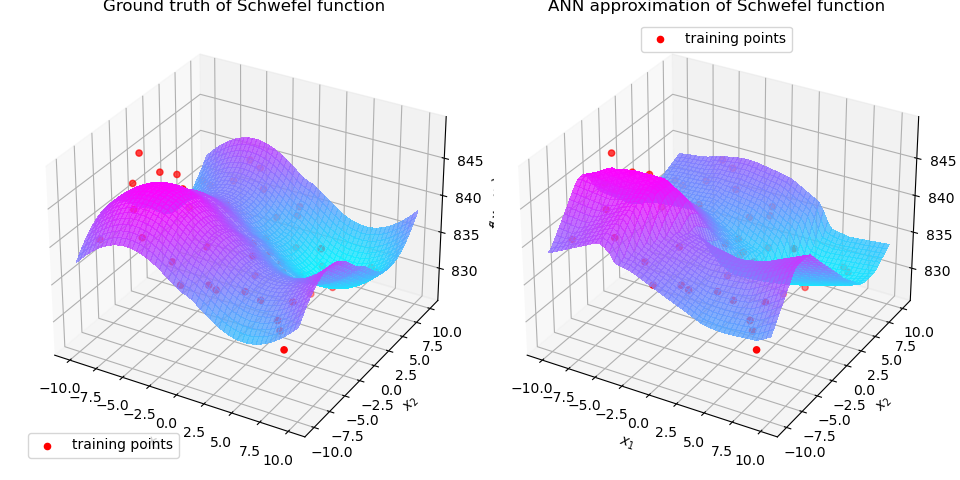

In [41]:
fig8 # plot surfaces for ANN

In [42]:
# Compute R2 for the ANN model
y_noisy_test_ANNpred = history.model.predict(X_test_scaled)
ANN_noisy_r2_value = r2_score(y_noisy_test, scaler_y.inverse_transform(y_noisy_test_ANNpred))
# note the transformation of the outputs back to the original scale

print('R2 score for ANN = ', ANN_noisy_r2_value)

R2 score for ANN =  0.7532259205501637


## Don't forget to "play" with this notebook

* **Try learning different functions**: go to the beginning of the notebook and change the benchmark function to be learned (e.g. Levy function)
* Use different noise levels
* Try different kernels for the GPR
* Do a Grid Search to find better parameters for the ANN
* Investigate the role of "early stopping" in the ANN

There are so many things that you can do to go deeper in the topic! Have some fun with it!

**Important Note:** Despite this notebook being dedicated to 3D surfaces (2 features and 1 target), the algorithms are general. In principle, they can perform regression for any dimensionality of features and targets (although for GPR if you want more than one output you have to consider modifications to the method). The codes do not change significantly, but visualizing data can be a challenge. The simplest solution is to project the space back to a 3D space. You will do that in your projects.

# 2. Multidimensional classification

Here's some good news:

* If you understand regression with supervised learning... Then, performing classification with supervised learning is very similar!

But first: what is classification?

* Classification problems occur when the target (output) is **discrete**, instead of being a continuous variable like we did in regression problems.

* A simple classification problem that is very common to consider when first learning about this topic is the [Iris dataset](http://archive.ics.uci.edu/ml/datasets/Iris) created by UCI researchers in 1936.

* I downloaded the .CSV file from [Kaggle](https://www.kaggle.com/) and it is included in the docs folder of this GitHub repository.

Therefore, we can load that .CSV file into a Pandas DataFrame!

In [43]:
# Load the Iris dataset.
iris_data = pd.read_csv('docs/Iris.csv')

print(iris_data)

      Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
0      1            5.1           3.5            1.4           0.2   
1      2            4.9           3.0            1.4           0.2   
2      3            4.7           3.2            1.3           0.2   
3      4            4.6           3.1            1.5           0.2   
4      5            5.0           3.6            1.4           0.2   
..   ...            ...           ...            ...           ...   
145  146            6.7           3.0            5.2           2.3   
146  147            6.3           2.5            5.0           1.9   
147  148            6.5           3.0            5.2           2.0   
148  149            6.2           3.4            5.4           2.3   
149  150            5.9           3.0            5.1           1.8   

            Species  
0       Iris-setosa  
1       Iris-setosa  
2       Iris-setosa  
3       Iris-setosa  
4       Iris-setosa  
..              ...  
145  

#### A short note

In fact, the Iris dataset is **so common**, that scikit-learn already has it saved and it can be loaded directly from the scikit-learn code, as shown below.

In [44]:
# In case you wanted to load the Iris dataset directly from scikit-learn.
from sklearn.datasets import load_iris

iris = load_iris() # load Iris dataset that already exists in Scikit-learn
# Convert it to a Pandas Dataframe
data1 = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

# You can print(data1) and see that it is the same dataset.

# But I think it is informative to understand the usual process
# in machine learning: someone gives us a dataset (or we download
# it from somewhere) and we usually load it with Pandas due to its
# versatility.

When you start a new problem, the first step is:

* Get to know the dataset.

What are the features? And the targets? What kind of data preprocessing should we do? What do we know *before* using machine learning tools to analyze the dataset?

<img src="docs/iris_dataset_explanation.png" title="Flower to explain Iris dataset" width="25%" align="right">

Here's a nice image to understand the dataset.

The dataset is quite simple! It has:

* 4 Features (inputs): sepal length, sepal width, petal length, petal width


* 1 Target (output): iris species (3 different species with 50 samples each)

So, the dataset has 150 samples of 3 different species of iris flower (50 samples per species) and each flower has 4 features that characterize it: the length and width of the petal and the sepal (see figure on the right).

**Our task**: Learn from part of the dataset how to classify a new iris flower into one of the 3 species!

Note: This example is straight out of Scikit-learn (but simplified)

In [45]:
# Let's only use the first two features (ignoring the other 2).
X_2d = iris_data.loc[:, ['SepalLengthCm','SepalWidthCm'] ].values # just use 2 inputs (features)
y_string = iris_data.loc[:, 'Species'].values

print('y_string = ',y_string,'\n\n')

y_string =  ['Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iri

It's also very common to convert our target (output) data from strings to integers!

In this case we have three discrete target values ('Iris-setosa', 'Iris-versicolor' and 'Iris-virginica') so we can convert to 0, 1 and 2

In [46]:
# Pandas makes this very easy for us. Just one line!
y = pd.Categorical(pd.factorize(y_string)[0])

print('y = ',y)

y =  [0, 0, 0, 0, 0, ..., 2, 2, 2, 2, 2]
Length: 150
Categories (3, int64): [0, 1, 2]


Let's consider one of the simplest supervised learning classification algorithms: **Support Vector Machines**.

Note: we can also do classification with Gaussian Processes and with Artificial Neural Networks. But I just want to show a few other examples of algorithms because you will need to search for algorithms you don't know, understand them and decide if they are applicable or not to your problem of interest.

In [47]:
from sklearn import svm
# we create an instance of SVM and fit out data. We do not scale our data (this dataset is quite simple)
C = 1.0  # SVM regularization parameter
svm_model = svm.SVC(kernel='rbf', gamma=0.7, C=C)

svm_model.fit(X_2d, y)

SVC(gamma=0.7)

<IPython.core.display.Javascript object>


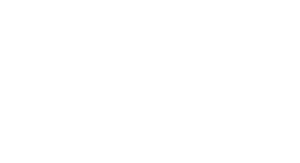

In [48]:
# Set-up 2x2 grid for plotting.
fig9, ax9 = plt.subplots()
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X1, X2 = X_2d[:, 0], X_2d[:, 1]

X1_min, X1_max = X1.min() - 1, X1.max() + 1 # define min and max of feature 0
X2_min, X2_max = X2.min() - 1, X2.max() + 1 # define min and max of feature 1
X1_grid, X2_grid = np.meshgrid(np.arange(X1_min, X1_max, 0.02),
                               np.arange(X2_min, X2_max, 0.02))

y_pred = svm_model.predict(np.c_[X1_grid.ravel(), X2_grid.ravel()])
Y_grid = y_pred.reshape(X1_grid.shape)

ax9.contourf(X1_grid, X2_grid, Y_grid, cmap=cm.coolwarm, alpha=0.8)

ax9.scatter(X1, X2, c=y, cmap=cm.coolwarm, s=20, edgecolors='k')
ax9.set_xlim(X1_grid.min(), X1_grid.max())
ax9.set_ylim(X2_grid.min(), X2_grid.max())
ax9.set_xlabel('Sepal length')
ax9.set_ylabel('Sepal width')
ax9.set_xticks(())
ax9.set_yticks(())
ax9.set_title('SVC with RBF kernel')

plt.close(fig9)

<IPython.core.display.Javascript object>


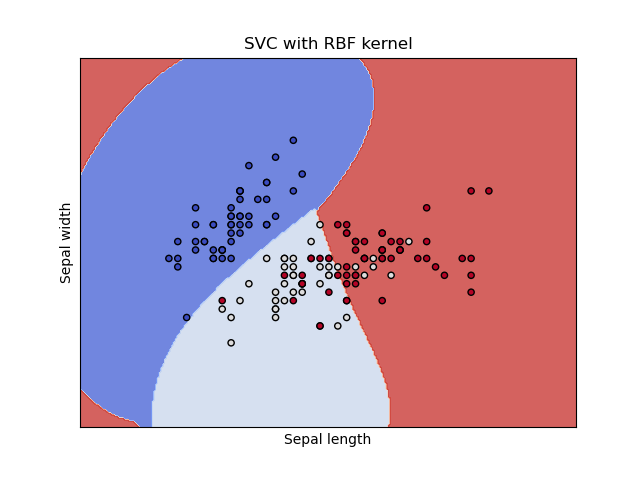

In [49]:
fig9 # classification plot using only 2 features ('SepalLengthCm' and 'SepalWidthCm')

Let's now plot for all 4 features, instead of considering only the first 2.

Let's also use a different classifier. Instead of Support Vector Machines (SVM), we will use **Decision Trees**.

The following is also an example from Scikit-learn.

In [50]:
# Load all the features and the target variables:
X = iris_data.iloc[:, 1:5 ].values # now using all 4 features (inputs)
feature_names = iris_data.columns.values[1:5] # not including the "ID" column

y_strings = iris_data.loc[:, 'Species'].values
target_names = iris_data.loc[:, 'Species'].unique()

print(feature_names)
print(target_names)

['SepalLengthCm' 'SepalWidthCm' 'PetalLengthCm' 'PetalWidthCm']
['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


<IPython.core.display.Javascript object>


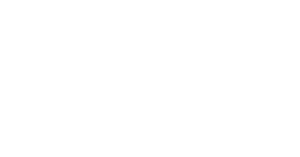

In [51]:
from sklearn.tree import DecisionTreeClassifier
# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

fig10, ax10 = plt.subplots() # open figure
for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    #X_temp = iris.data[:, pair]
    #y_temp = iris.target

    X_temp = X[:, pair]
    
    # Train
    clf = DecisionTreeClassifier().fit(X_temp, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x1_min, x1_max = X_temp[:, 0].min() - 1, X_temp[:, 0].max() + 1
    x2_min, x2_max = X_temp[:, 1].min() - 1, X_temp[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, plot_step),
                         np.arange(x2_min, x2_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Y = clf.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Y = Y.reshape(xx1.shape)
    cs = plt.contourf(xx1, xx2, Y, cmap=cm.RdYlBu)

    plt.xlabel(feature_names[pair[0]])
    plt.ylabel(feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X_temp[idx, 0], X_temp[idx, 1],
                    c=color, label=target_names[i],cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")
plt.close(fig10)

<IPython.core.display.Javascript object>


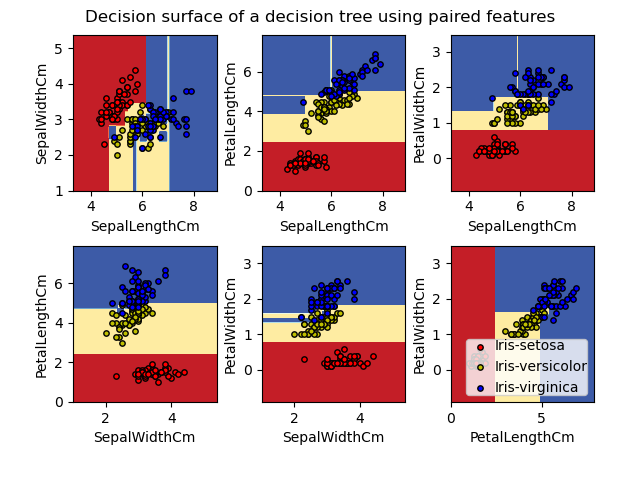

In [52]:
fig10 # classification plot with Decision Trees for all 4 features (showing them in pairs of 2)

# Solution to the Homework

1. Code to answer question 1 (scaling only inputs):

``` python
# CODE TO ANSWER QUESTION 1 OF THE HOMEWORK FOR THIS LECTURE
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, n_restarts_optimizer=20)

# The ONLY difference is that we will train the model on SCALED inputs (not outputs)
gp_model.fit(X_train_scaled, y_train) # here I am not scaling the target variable; only the features.

# Make the prediction on the entire dataset (for plotting)
y_data_GPpred = gp_model.predict(X_data_scaled)

# Plot figure comparing ground truth and GPR prediction (where we only scaled the inputs)
fig = plt.figure(figsize=plt.figaspect(0.5)); ax = []
# Grround truth
ax.append(fig.add_subplot(1, 2, 1, projection='3d'))
surf = ax[0].plot_surface(X1_grid, X2_grid, Y_grid,
                          cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax[0].set_xlabel('$x_1$', fontsize=15)
ax[0].set_ylabel('$x_2$', fontsize=15)
ax[0].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax[0].set_title("Ground truth of %s function" % function_name, fontsize=15)

# GPR approximation (where we only scaled the inputs)
ax.append(fig.add_subplot(1, 2, 2, projection='3d'))
Y_grid_data_GPpred = np.reshape(y_data_GPpred,np.shape(X1_grid)) # convert targets into grid format for plotting
surf = ax[1].plot_surface(X1_grid, X2_grid, Y_grid_data_GPpred,
                              cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax[1].set_xlabel('$x_1$', fontsize=15)
ax[1].set_ylabel('$x_2$', fontsize=15)
ax[1].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax[1].set_title("GPR mean for %s function" % function_name, fontsize=15)
ax[1].scatter(X_train[:,0], X_train[:,1], y_train,
                  marker='o', color='red', label="training points")
ax[1].legend(loc='upper center')

```

By plotting this we see that there are still convergence issues because the inputs of the Schwefel function are within reasonable bounds: $x_1 \in [-10, 10]$ and $x_2 \in [-10, 10]$. So, even if we scale the inputs, the difference will not be very large!

---

2. Code to answer question 2

``` python
# CODE TO ANSWER QUESTION 2 OF THE HOMEWORK FOR THIS LECTURE
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, n_restarts_optimizer=20)

# The ONLY difference is that we will train the model on SCALED inputs (not outputs)
gp_model.fit(X_train, y_train_scaled) # here I am not scaling the target variable; only the features.

# Make the prediction on the entire dataset (for plotting)
y_data_GPpred_scaled = gp_model.predict(X_data) # NOTE THAT THE MODEL OUTPUTS ARE SCALED
y_data_GPpred = scaler_y.inverse_transform(y_data_GPpred_scaled)

# Plot figure comparing ground truth and GPR prediction (where we only scaled the inputs)
fig = plt.figure(figsize=plt.figaspect(0.5)); ax = []
# Grround truth
ax.append(fig.add_subplot(1, 2, 1, projection='3d'))
surf = ax[0].plot_surface(X1_grid, X2_grid, Y_grid,
                          cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax[0].set_xlabel('$x_1$', fontsize=15)
ax[0].set_ylabel('$x_2$', fontsize=15)
ax[0].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax[0].set_title("Ground truth of %s function" % function_name, fontsize=15)

# GPR approximation (where we only scaled the inputs)
ax.append(fig.add_subplot(1, 2, 2, projection='3d'))
Y_grid_data_GPpred = np.reshape(y_data_GPpred,np.shape(X1_grid)) # convert targets into grid format for plotting
surf = ax[1].plot_surface(X1_grid, X2_grid, Y_grid_data_GPpred,
                              cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax[1].set_xlabel('$x_1$', fontsize=15)
ax[1].set_ylabel('$x_2$', fontsize=15)
ax[1].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax[1].set_title("GPR mean for %s function" % function_name, fontsize=15)
ax[1].scatter(X_train[:,0], X_train[:,1], y_train,
                  marker='o', color='red', label="training points")
ax[1].legend(loc='upper center')

```

By plotting this we see that it works well! Scaling the output is important for the Schwefel function because for the domain that we are considering the output is within the following bounds: $y \in [830, 846]$. This is a reasonable large value, which makes it harder to optimize the likelihood!

**Conclusion**: Usually, scaling the data doesn't *hurt* but it can really help! Pre-processing your datasets with appropriate scalers for both inputs and outputs is pretty important for many methods.

* Short note: A few methods do not care if you scale the data (decision trees are a great example). But again, if you use an appropriate scaler, it rarely makes things worst. So, most of the time, scaling the data is good practice.

---

3. Code to create our own version of the StandardScaler where the standard deviation of the output is scaled correctly.

``` python
# CODE TO ANSWER QUESTION 3 OF THE HOMEWORK FOR THIS LECTURE
# Let's create a class called MyStandardScaler where we correct the inverse_transform for the std
class MyStandardScaler:
    def __init__(self):
        pass

    def fit(self, x):
        self.mu  = np.mean(x)
        self.std = np.std(x)

    def transform(self, x):
        return (x-self.mu)/self.std

    def inverse_transform_mean(self, x):
        # Inverse transform for the mean (same as inverse_transform in scikit-learn)
        return x*self.std + self.mu

    def inverse_transform_std(self, x):
        # Inverse transform for standard deviation (this does not exist in scikit-learn)
        return x*self.std
        
# Then, we can use MyStandardScaler exactly in the same way as scikit-learn's StandardScaler:
# Scaling inputs with MyStandardScaler:
MyScaler_x = MyStandardScaler()
MyScaler_x.fit(X_train)
#
X_train_scaled = MyScaler_x.transform(X_train)
X_test_scaled = MyScaler_x.transform(X_test)
X_data_scaled = MyScaler_x.transform(X_data)

# Now scaling outputs with MyStandardScaler
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_data = y_data.reshape(-1, 1)
#
MyScaler_y = MyStandardScaler()
MyScaler_y.fit(y_train)
#
y_train_scaled = MyScaler_y.transform(y_train)
y_test_scaled = MyScaler_y.transform(y_test)
y_data_scaled = MyScaler_y.transform(y_data)

# Then, we can train the GP and plot the results just like we did in the Lecture.
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) # This is the standard RBF kernel
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, n_restarts_optimizer=20) # using a small alpha
gp_model.fit(X_train_scaled, y_train_scaled) # train on inputs & outputs scaled by MyStandardScaler

# Make the prediction on the entire dataset (for plotting), both for mean and standard deviation
y_data_GPpred_scaled, sigma_data_GPpred_scaled = gp_model.predict(X_data_scaled, return_std=True)
y_data_GPpred = MyScaler_y.inverse_transform_mean(y_data_GPpred_scaled) # unscaled mean
sigma_data_GPpred = MyScaler_y.inverse_transform_std(sigma_data_GPpred_scaled.reshape(-1, 1)) # unscaled std

# Same thing for the test data
y_test_GPpred_scaled, sigma_test_GPpred_scaled = gp_model.predict(X_test_scaled, return_std=True)
y_test_GPpred = MyScaler_y.inverse_transform_mean(y_test_GPpred_scaled)
sigma_test_GPpred = MyScaler_y.inverse_transform_std(sigma_test_GPpred_scaled.reshape(-1, 1))

# Plot figure comparing ground truth and GPR prediction (where we only scaled the inputs)
fig = plt.figure(figsize=plt.figaspect(0.5)); ax = []
# Grround truth
ax.append(fig.add_subplot(1, 2, 1, projection='3d'))
surf = ax[0].plot_surface(X1_grid, X2_grid, Y_grid,
                          cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax[0].set_xlabel('$x_1$', fontsize=15)
ax[0].set_ylabel('$x_2$', fontsize=15)
ax[0].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax[0].set_title("Ground truth of %s function" % function_name, fontsize=15)

# GPR approximation (where we only scaled the inputs)
ax.append(fig.add_subplot(1, 2, 2, projection='3d'))
Y_grid_data_GPpred = np.reshape(y_data_GPpred,np.shape(X1_grid)) # convert targets into grid format for plotting
surf = ax[1].plot_surface(X1_grid, X2_grid, Y_grid_data_GPpred,
                              cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax[1].set_xlabel('$x_1$', fontsize=15)
ax[1].set_ylabel('$x_2$', fontsize=15)
ax[1].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax[1].set_title("GPR mean for %s function" % function_name, fontsize=15)
ax[1].scatter(X_train[:,0], X_train[:,1], y_train,
                  marker='o', color='red', label="training points")
ax[1].legend(loc='upper center')
```

### You will explore these and other things in Part 3 of the Midterm Project...

Have fun!

/home/mabessa/miniconda3/envs/3dasm/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


<IPython.core.display.Javascript object>


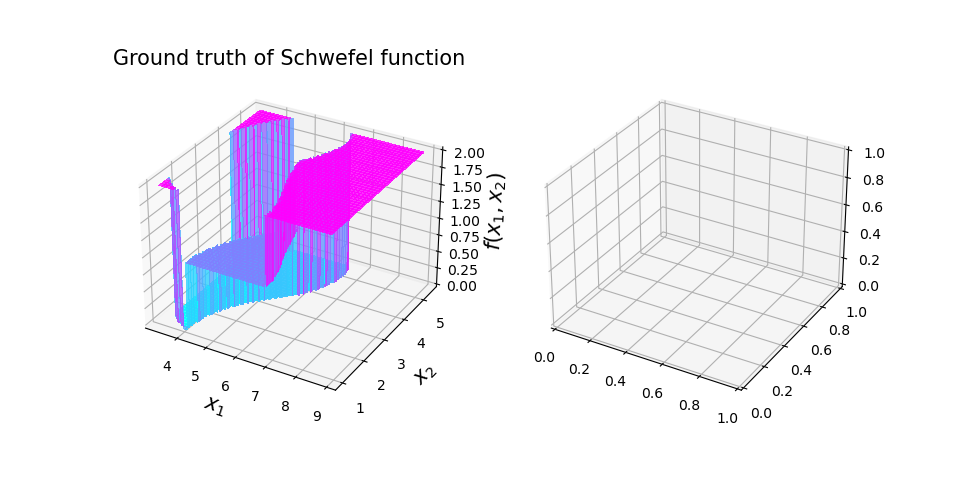

ValueError: cannot reshape array of size 2500 into shape (220,280)

In [53]:
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, n_restarts_optimizer=20)

# The ONLY difference is that we will train the model on SCALED inputs (not outputs)
gp_model.fit(X_train_scaled, y_train) # here I am not scaling the target variable; only the features.

# Make the prediction on the entire dataset (for plotting)
y_data_GPpred = gp_model.predict(X_data_scaled)

# Plot figure comparing ground truth and GPR prediction (where we only scaled the inputs)
fig = plt.figure(figsize=plt.figaspect(0.5)); ax = []
# Grround truth
ax.append(fig.add_subplot(1, 2, 1, projection='3d'))
surf = ax[0].plot_surface(X1_grid, X2_grid, Y_grid,
                          cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax[0].set_xlabel('$x_1$', fontsize=15)
ax[0].set_ylabel('$x_2$', fontsize=15)
ax[0].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax[0].set_title("Ground truth of %s function" % function_name, fontsize=15)

# GPR approximation (where we only scaled the inputs)
ax.append(fig.add_subplot(1, 2, 2, projection='3d'))
Y_grid_data_GPpred = np.reshape(y_data_GPpred,np.shape(X1_grid)) # convert targets into grid format for plotting
surf = ax[1].plot_surface(X1_grid, X2_grid, Y_grid_data_GPpred,
                              cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax[1].set_xlabel('$x_1$', fontsize=15)
ax[1].set_ylabel('$x_2$', fontsize=15)
ax[1].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax[1].set_title("GPR mean for %s function" % function_name, fontsize=15)
ax[1].scatter(X_train[:,0], X_train[:,1], y_train,
                  marker='o', color='red', label="training points")
ax[1].legend(loc='upper center')

In [ ]:
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, n_restarts_optimizer=20)

# The ONLY difference is that we will train the model on SCALED inputs (not outputs)
gp_model.fit(X_train, y_train_scaled) # here I am not scaling the target variable; only the features.

# Make the prediction on the entire dataset (for plotting)
y_data_GPpred_scaled = gp_model.predict(X_data) # NOTE THAT THE MODEL OUTPUTS ARE SCALED
y_data_GPpred = scaler_y.inverse_transform(y_data_GPpred_scaled)

# Plot figure comparing ground truth and GPR prediction (where we only scaled the inputs)
fig = plt.figure(figsize=plt.figaspect(0.5)); ax = []
# Grround truth
ax.append(fig.add_subplot(1, 2, 1, projection='3d'))
surf = ax[0].plot_surface(X1_grid, X2_grid, Y_grid,
                          cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax[0].set_xlabel('$x_1$', fontsize=15)
ax[0].set_ylabel('$x_2$', fontsize=15)
ax[0].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax[0].set_title("Ground truth of %s function" % function_name, fontsize=15)

# GPR approximation (where we only scaled the inputs)
ax.append(fig.add_subplot(1, 2, 2, projection='3d'))
Y_grid_data_GPpred = np.reshape(y_data_GPpred,np.shape(X1_grid)) # convert targets into grid format for plotting
surf = ax[1].plot_surface(X1_grid, X2_grid, Y_grid_data_GPpred,
                              cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax[1].set_xlabel('$x_1$', fontsize=15)
ax[1].set_ylabel('$x_2$', fontsize=15)
ax[1].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax[1].set_title("GPR mean for %s function" % function_name, fontsize=15)
ax[1].scatter(X_train[:,0], X_train[:,1], y_train,
                  marker='o', color='red', label="training points")
ax[1].legend(loc='upper center')

In [ ]:
# CODE TO ANSWER QUESTION 3 OF THE HOMEWORK FOR THIS LECTURE
# Let's create a class called MyStandardScaler where we correct the inverse_transform for the std
class MyStandardScaler:
    def __init__(self):
        pass

    def fit(self, x):
        self.mu  = np.mean(x)
        self.std = np.std(x)

    def transform(self, x):
        return (x-self.mu)/self.std

    def inverse_transform_mean(self, x):
        # Inverse transform for the mean (same as inverse_transform in scikit-learn)
        return x*self.std + self.mu

    def inverse_transform_std(self, x):
        # Inverse transform for standard deviation (this does not exist in scikit-learn)
        return x*self.std
        
# Then, we can use MyStandardScaler exactly in the same way as scikit-learn's StandardScaler:
# Scaling inputs with MyStandardScaler:
MyScaler_x = MyStandardScaler()
MyScaler_x.fit(X_train)
#
X_train_scaled = MyScaler_x.transform(X_train)
X_test_scaled = MyScaler_x.transform(X_test)
X_data_scaled = MyScaler_x.transform(X_data)

# Now scaling outputs with MyStandardScaler
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_data = y_data.reshape(-1, 1)
#
MyScaler_y = MyStandardScaler()
MyScaler_y.fit(y_train)
#
y_train_scaled = MyScaler_y.transform(y_train)
y_test_scaled = MyScaler_y.transform(y_test)
y_data_scaled = MyScaler_y.transform(y_data)

# Then, we can train the GP and plot the results just like we did in the Lecture.
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) # This is the standard RBF kernel
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, n_restarts_optimizer=20) # using a small alpha
gp_model.fit(X_train_scaled, y_train_scaled) # train on inputs & outputs scaled by MyStandardScaler

# Make the prediction on the entire dataset (for plotting), both for mean and standard deviation
y_data_GPpred_scaled, sigma_data_GPpred_scaled = gp_model.predict(X_data_scaled, return_std=True)
y_data_GPpred = MyScaler_y.inverse_transform_mean(y_data_GPpred_scaled) # unscaled mean
sigma_data_GPpred = MyScaler_y.inverse_transform_std(sigma_data_GPpred_scaled.reshape(-1, 1)) # unscaled std

# Same thing for the test data
y_test_GPpred_scaled, sigma_test_GPpred_scaled = gp_model.predict(X_test_scaled, return_std=True)
y_test_GPpred = MyScaler_y.inverse_transform_mean(y_test_GPpred_scaled)
sigma_test_GPpred = MyScaler_y.inverse_transform_std(sigma_test_GPpred_scaled.reshape(-1, 1))

# Plot figure comparing ground truth and GPR prediction (where we only scaled the inputs)
fig = plt.figure(figsize=plt.figaspect(0.5)); ax = []
# Grround truth
ax.append(fig.add_subplot(1, 2, 1, projection='3d'))
surf = ax[0].plot_surface(X1_grid, X2_grid, Y_grid,
                          cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax[0].set_xlabel('$x_1$', fontsize=15)
ax[0].set_ylabel('$x_2$', fontsize=15)
ax[0].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax[0].set_title("Ground truth of %s function" % function_name, fontsize=15)

# GPR approximation (where we only scaled the inputs)
ax.append(fig.add_subplot(1, 2, 2, projection='3d'))
Y_grid_data_GPpred = np.reshape(y_data_GPpred,np.shape(X1_grid)) # convert targets into grid format for plotting
surf = ax[1].plot_surface(X1_grid, X2_grid, Y_grid_data_GPpred,
                              cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax[1].set_xlabel('$x_1$', fontsize=15)
ax[1].set_ylabel('$x_2$', fontsize=15)
ax[1].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax[1].set_title("GPR mean for %s function" % function_name, fontsize=15)
ax[1].scatter(X_train[:,0], X_train[:,1], y_train,
                  marker='o', color='red', label="training points")
ax[1].legend(loc='upper center')